# OBJETIVO: Predecir el precio de las viviendas a partir de un historial de ventas en la región de Connecticut
<br> <br/>
## Contexto comercial

El mercado de bienes raíces en Estados Unidos es extremadamente diverso y dinámico. Abarca una amplia variedad de propiedades, desde viviendas unifamiliares hasta edificios comerciales, terrenos vacantes y propiedades de inversión.

Para iniciar una negociación es muy útil contar con un "Precio Tentativo" que dependa de un historial de ventas casa. Asimismo, resultaría muy interesante contar con una estimación automática, dejando de lado el criterio del tasador que quizás podría ser subjetivo.
<br> <br/>
## Problema comercial
Al no contar con el precio estimado de la vivienda, es muy difícil para el intermediario poder establecer un punto de negociación de precio entre comprador y vendedor. Por ello es que se requiere contar con un precio estimado en función a ventas históricas de casas similares para que el proceso de negociación sea más ameno para ambas partes.
<br> <br/>
### Contexto analítico
Para poder desarrollar el modelo se cuenta con un listado de todas las ventas de bienes raíces con un precio de venta de $2,000 o más que ocurren entre el 1 de octubre y el 30 de septiembre de cada año, haciendo un total de 997.213 registros de ventas. Para cada registro de venta, el archivo incluye: ciudad, dirección de la propiedad, fecha de venta, tipo de propiedad (residencial, departamento, comercial, industrial o terreno baldío), precio de venta y tasación de la propiedad.

Los datos se recopilan de acuerdo con los Estatutos Generales de Connecticut

Las ventas anuales de bienes raíces se informan por año de lista general (del 1 de octubre al 30 de septiembre de cada año). Por ejemplo, las ventas del GL 2018 son del 01/10/2018 al 30/09/2019.

Metadatos actualizados: 12 de agosto de 2023
<br> <br/>
Las variables disponibles (14) son las siguientes:
<br> <br/>
1. Serial Number: número de serie
2. List Year: año de la venta. (recordemos que el año se considera desde 01/10 al 30/09 de cada año calendario)
3. Date Recorded: fecha de registro
4. Town: ciudad
5. Address: dirección
6. Assessed Value: valor tasado
7. Sale Amount: valor de venta
8. Sales Ratio: ratio de venta (valor tasado / valor de venta)
9. Property Type: tipo de propiedad
10. Residential Type: tipo residencial
11. Non Use Code: código de no uso
12. Assessor Remarks: Observaciones del asesor
13. OPM remarks: Comentario de la operación
14. Location: ubicación

In [1]:
# Importamos paquetería necesaria.

import pandas as pd
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.api as sm

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from google.colab import drive
from datetime import datetime


In [2]:
# Montamos el Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Definimos el directorio de trabajo a la ruta deseada
path = '/content/drive/MyDrive/Colab Notebooks/Entregas/17 - Entrega del proyecto final/Real_Estate_Sales_2001-2020_GL.csv'

# Levantamos el archivo
df = pd.read_csv(path, low_memory=False)
print(df.head())
print(df.shape)

   Serial Number  List Year Date Recorded     Town                Address  \
0        2020348       2020    09/13/2021  Ansonia        230 WAKELEE AVE   
1          20002       2020    10/02/2020  Ashford        390 TURNPIKE RD   
2         200212       2020    03/09/2021     Avon       5 CHESTNUT DRIVE   
3         200243       2020    04/13/2021     Avon  111 NORTHINGTON DRIVE   
4         200377       2020    07/02/2021     Avon     70 FAR HILLS DRIVE   

   Assessed Value  Sale Amount  Sales Ratio Property Type Residential Type  \
0        150500.0     325000.0       0.4630    Commercial              NaN   
1        253000.0     430000.0       0.5883   Residential    Single Family   
2        130400.0     179900.0       0.7248   Residential            Condo   
3        619290.0     890000.0       0.6958   Residential    Single Family   
4        862330.0    1447500.0       0.5957   Residential    Single Family   

  Non Use Code Assessor Remarks OPM remarks Location  
0          Na

# Variable Target: Sale Amount

La variable objetivo es el precio de venta de la propiedad.

Esta variable es de tipo **numérica**
<br> <br/>
A continuación, se presentarán algunas estadísticas para entender el comportamiento, formato y distribución de esta variable.

In [5]:
# Algunas estadísticas
variable_target = df['Sale Amount']
pd.options.display.float_format = '{:.1f}'.format # quitamos el formato de notación cientifica.
variable_target.describe().round(0)

count       997213.0
mean        391151.0
std        5347270.0
min              0.0
25%         140000.0
50%         225000.0
75%         365000.0
max     5000000000.0
Name: Sale Amount, dtype: float64

In [6]:
# Analizamos df en busca de valores menores a los 2.000
df_filtrado = df[df['Sale Amount'] < 2000]
df_filtrado

,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Non Use Code,Assessor Remarks,OPM remarks,Location
86,10045,2001,01/03/2002,Bethany,9 SIMPSON CT,96590.0,0.0,0.0,NaN,NaN,1,NaN,NaN,NaN
139,10041,2001,10/04/2001,Stratford,86 MINOR CROSS,107090.0,0.0,0.0,NaN,NaN,1,NaN,NaN,NaN
150,10482,2001,01/10/2002,Stratford,129 BAYBERRY LN,140390.0,0.0,0.0,NaN,NaN,1,NaN,NaN,NaN
159,10466,2001,01/07/2002,Stratford,1086 ESSEX PL,150640.0,0.0,0.0,NaN,NaN,1,NaN,NaN,NaN
185,10124,2001,10/23/2001,Stratford,1093 BARNUM AVE,200980.0,0.0,0.0,NaN,NaN,3,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902489,180046,2018,10/29/2018,Berlin,63 STONY MILL LANE,137600.0,0.0,0.0,Condo,Condo,29 - No Consideration,non-qualified sale - life use,NaN,NaN
914892,180006,2018,10/05/2018,Winchester,53 CENTER ST,79100.0,0.0,0.0,Two Family,Two Family,18 - In Lieu Of Foreclosure,IN LEIU OF FORECLOSURE,NaN,NaN
921479,180032,2018,10/31/2018,Winchester,131 BELVIDERE,75950.0,0.0,0.0,Single Family,Single Family,14 - Foreclosure,SALE OF FORECLOSURE,NaN,NaN
924767,180005,2018,10/03/2018,Woodstock,ENGLISH NEIGHBORHOOD RD,5900.0,1200.0,4.9,NaN,NaN,28 - Use Assessment,NaN,NaN,NaN


---
Detectamos 2.139 registros cuyo precio de venta es menor a los 2.000 dólares.
Consideraremos como información incorrecta todas las ventas con precio de venta menor a 2.000 dólares, debido a que el enunciado nos dice que este conjunto de datos pertenece a todas las ventas mayores o iguales a 2.000 dólares realizadas en un periodo del tiempo.
Procederemos a eliminarlos de nuestra base de datos.

---

In [7]:
# Eliminamos registros de la columna Sale Amount menores a 2.000
df = df[df['Sale Amount'] > 2000]

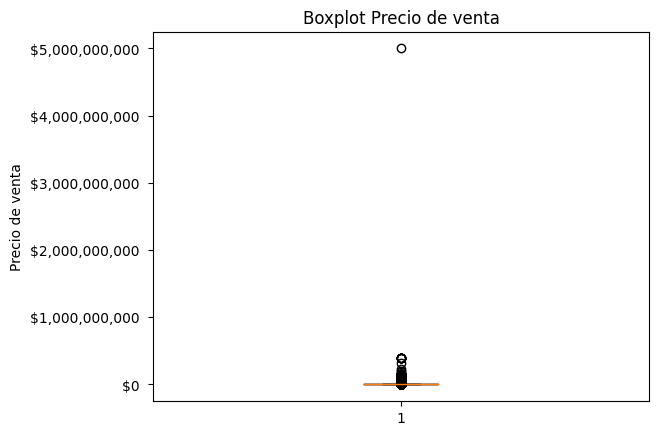

In [8]:
#Analizamos la variable target en busca de outliers que puedan entorpecer nuestro modelo.
# Boxplot
fig, ax = plt.subplots()
ax.boxplot(df['Sale Amount'])
ax.set_title('Boxplot Precio de venta')
ax.set_xlabel('')
ax.set_ylabel('Precio de venta')
ax.yaxis.set_major_formatter('${:,.0f} '.format)

In [9]:
# Analizamos df en busca de valores mayores a 500.000.000
df_filtrado1 = df[df['Sale Amount'] > 500000000]
df_filtrado1

,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Non Use Code,Assessor Remarks,OPM remarks,Location
59835,20200091,2020,08/19/2021,Willington,456 TOLLAND TPKE,2238530.0,5000000000.0,0.0,Apartments,NaN,25 - Other,APARTMENTS-COMMERICAL,INCORRECT SALE PRICE,NaN


In [10]:
# Eliminamos registros de la columan Sale Amount mayores a 500.000.000
df = df[df['Sale Amount'] < 500000000]

In [11]:
# Algunas estadísticas nuevamente
variable_target = df['Sale Amount']
pd.options.display.float_format = '{:.1f}'.format # quitamos el formato de notación cientifica.
variable_target.describe().round(0)

count      994661.0
mean       387127.0
std       1880417.0
min          2010.0
25%        140000.0
50%        225000.0
75%        365000.0
max     395500000.0
Name: Sale Amount, dtype: float64

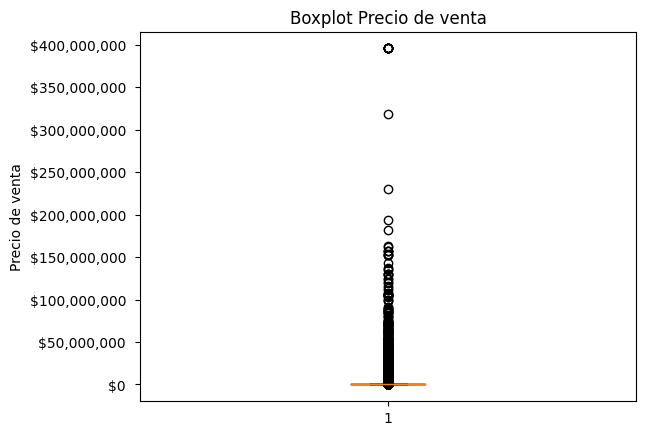

In [12]:
#Analizamos la variable target en busca de outliers que puedan entorpecer nuestro modelo.
# Boxplot
fig, ax = plt.subplots()
ax.boxplot(df['Sale Amount'])
ax.set_title('Boxplot Precio de venta')
ax.set_xlabel('')
ax.set_ylabel('Precio de venta')
ax.yaxis.set_major_formatter('${:,.0f} '.format)

In [13]:
# Analizamos df en busca de valores mayores a 250.000.000
df_filtrado2 = df[df['Sale Amount'] > 250000000]
df_filtrado2

,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Non Use Code,Assessor Remarks,OPM remarks,Location
60894,20200078,2020,07/06/2021,Willington,224 RIVER ROAD,223070.0,318790019.0,0.0,Residential,Single Family,25 - Other,COLONIAL,INCORRECT SALE PRICE - NO MLS,POINT (-72.30341 41.86603)
799639,160393,2016,12/06/2016,Stamford,115 TOWNE STREET,50820110.0,395500000.0,0.1,NaN,NaN,25 - Other,ENTERPRISE ZONE & MULTIPLE PARCEL SALE,NaN,NaN
801957,160389,2016,12/06/2016,Stamford,200 HENRY STREET # 3,10829090.0,395500000.0,0.0,NaN,NaN,25 - Other,ENTERPRISE ZONE & MULTIPLE PARCEL SALE,NaN,POINT (-73.53597 41.0442)
825219,160390,2016,12/06/2016,Stamford,200 HENRY STREET # 4,10935790.0,395500000.0,0.0,NaN,NaN,25 - Other,ENTERPRISE ZONE & MULTIPLE PARCEL SALE,NaN,NaN
835231,160386,2016,12/06/2016,Stamford,120 TOWNE STREET,56144510.0,395500000.0,0.1,NaN,NaN,25 - Other,ENTERPRISE ZONE & MULTIPLE PARCEL SALE,NaN,POINT (-73.53568 41.04536)
839109,160394,2016,12/06/2016,Stamford,301-401 COMMONS PARK SOUTH # C,92447590.0,395500000.0,0.2,NaN,NaN,25 - Other,ENTERPRISE ZONE & MULTIPLE PARCEL SALE,NaN,NaN
844492,160388,2016,12/06/2016,Stamford,200 HENRY STREET # 2,3200720.0,395500000.0,0.0,NaN,NaN,25 - Other,ENTERPRISE ZONE & MULTIPLE PARCEL SALE,NaN,NaN
845330,160391,2016,12/06/2016,Stamford,200 HENRY STREET # 5,3307410.0,395500000.0,0.0,NaN,NaN,25 - Other,ENTERPRISE ZONE & MULTIPLE PARCEL SALE,NaN,NaN
847108,160387,2016,12/06/2016,Stamford,200 HENRY STREET # 1,10669060.0,395500000.0,0.0,NaN,NaN,25 - Other,ENTERPRISE ZONE & MULTIPLE PARCEL SALE,NaN,NaN
847797,160392,2016,12/06/2016,Stamford,110 TOWNE STREET,23290450.0,395500000.0,0.1,NaN,NaN,25 - Other,ENTERPRISE ZONE & MULTIPLE PARCEL SALE,NaN,NaN


---
Entendemos que todos los valores de Sale Amount no tienen sentido.

1) Tenemos una diferencia entre Assessed Value y Sale Amount exagerado.

2) El precio de venta en la mayoría de estos casos es el mismo. (presume error).

3) Ratio es 0.

Procederemos a eliminarlos.

---

In [14]:
# Eliminamos registros de la columan Sale Amount mayores a 250.000.000
df = df[df['Sale Amount'] < 250000000]

In [15]:
# Algunas estadísticas nuevamente
variable_target = df['Sale Amount']
pd.options.display.float_format = '{:.1f}'.format # quitamos el formato de notación cientifica.
variable_target.describe().round(0)

count      994651.0
mean       383232.0
std       1421787.0
min          2010.0
25%        140000.0
50%        225000.0
75%        365000.0
max     230043624.0
Name: Sale Amount, dtype: float64

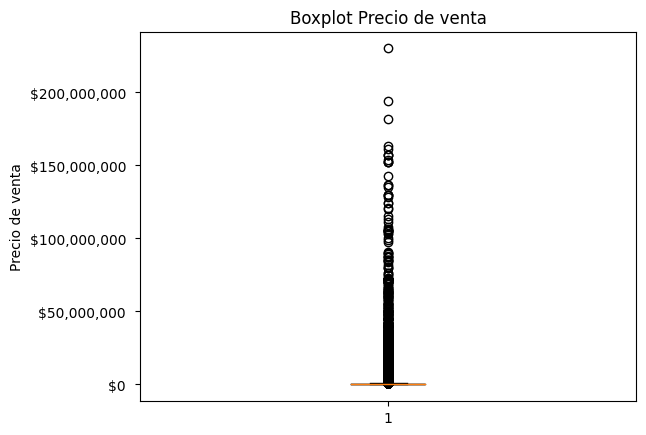

In [16]:
#Analizamos la variable target en busca de outliers que puedan entorpecer nuestro modelo.
# Boxplot
fig, ax = plt.subplots()
ax.boxplot(df['Sale Amount'])
ax.set_title('Boxplot Precio de venta')
ax.set_xlabel('')
ax.set_ylabel('Precio de venta')
ax.yaxis.set_major_formatter('${:,.0f} '.format)

Text(0.5, 1.0, 'Distribución de Sale Amount')

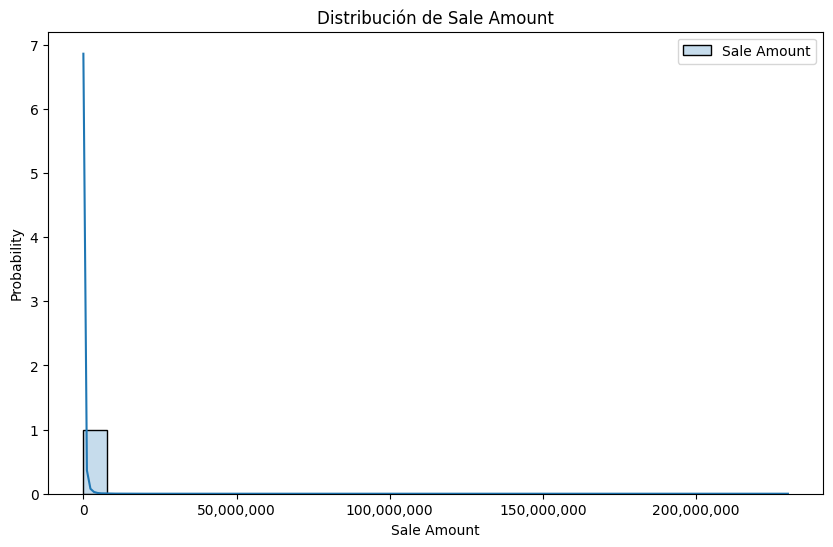

In [17]:
# Histograma variable target
plt.figure(figsize=(10, 6))
# Histograma
ax = sns.histplot(data = df,
             x = 'Sale Amount',
             bins = 30,
             alpha = 0.25,
             kde = True,
             stat='probability',
             label='Sale Amount')

ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
plt.legend()
plt.title('Distribución de Sale Amount')

---
Seguimos detectando valores atípicos y mucha concentración de datos en un rango de precios particular, por lo que procederemos a calcular el rango intercuartílico con el que continuaremos analizando.

---

In [18]:
# Seleccionar solo las columnas numéricas
df_numeric_IQR = df.select_dtypes(include=['number'])

In [19]:
# Calculamos el rango intercuartílico (IQR) para Sale Amount

Q1 = df_numeric_IQR.quantile(0.25)
Q3 = df_numeric_IQR.quantile(0.75)
IQR = Q3 - Q1


In [20]:
# Identificamos valores atípicos

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

In [21]:
# Filtrar el DataFrame para eliminar los valores atípicos
df_sin_atipicos = df[~((df_numeric_IQR < limite_inferior) | (df_numeric_IQR > limite_superior)).any(axis=1)]


In [22]:
df = df_sin_atipicos

In [23]:
# Quitamos el formato de notación cientifica.
pd.set_option('display.float_format', '{:.2f}'.format)

In [24]:
# Analizamos estadísticamente nuevamente la variable.
variable_target1 = df['Sale Amount']
variable_target1.describe().round(0)

count   765750.00
mean    246026.00
std     135318.00
min       2030.00
25%     150000.00
50%     220000.00
75%     320000.00
max     702500.00
Name: Sale Amount, dtype: float64

Text(0.5, 1.0, 'Distribución de Sale Amount')

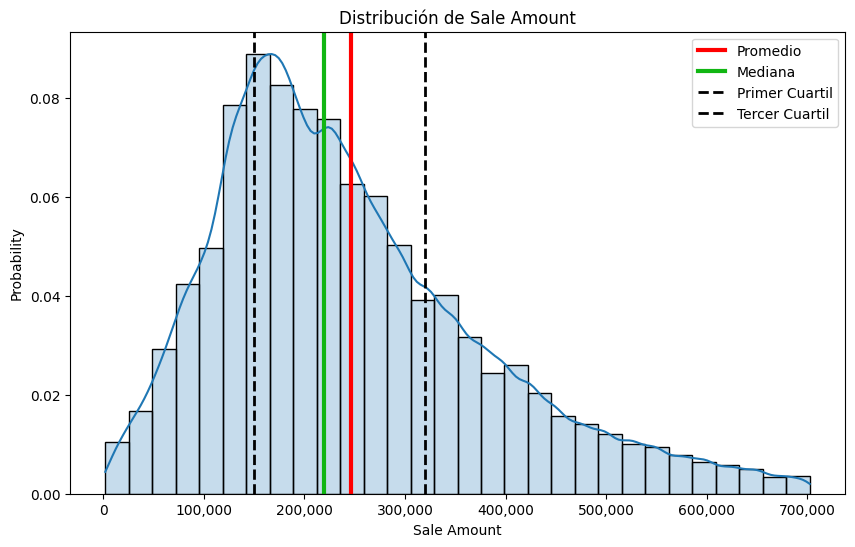

In [25]:
# Histograma variable target
# Primero calculamos algunas medidas que quiero presentar
media = variable_target1.mean()
mediana = variable_target1.median()
primer_cuartil = variable_target1.quantile(0.25)
tercer_cuartil = variable_target1.quantile(0.75)

# Luego graficamos
plt.figure(figsize=(10, 6))
# Histograma
ax = sns.histplot(data = df,
             x = 'Sale Amount',
             bins = 30,
             alpha = 0.25,
             kde = True,
             stat='probability')
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
# Agregamos línea de promedio
plt.axvline(x = media,
            color = 'red',
            linestyle = '-',
            label = 'Promedio',
            linewidth = 3)
# Agregamos línea de mediana
plt.axvline(x = mediana,
            color = '#11B613',
            linestyle = '-',
            label = 'Mediana',
            linewidth = 3)
# Agregamos línea de primer cuartil
plt.axvline(x = primer_cuartil,
            color = 'black',
            linestyle = '--',
            label = 'Primer Cuartil',
            linewidth = 2)
# Agregamos línea de tercer cuartil
plt.axvline(x = tercer_cuartil,
            color = 'black',
            linestyle = '--',
            label = 'Tercer Cuartil',
            linewidth = 2)

plt.legend()

plt.title('Distribución de Sale Amount')

Análisis Variable Target: Sale Amount

Como podemos observar la mediana es menor que el promedio, significa que la distribución es asimétrica hacia la derecha (positiva). Esto indica que la mayoría de los valores se encuentran en la parte inferior de la distribución, lo que hace que el tercer cuartil esté más cerca de la cola derecha de la distribución.

Al tratar con una variable target de este tipo de distribución, una buena práctica suele ser intentar predecir el logaritmo de la variable, para suavizar un poco la curva de valores posibles.
<br> <br/>
A continuación, se presentará el histograma del logaritmo de la variable target.

Text(0.5, 1.0, 'Distribución de Sale Amount transformado a Logaritmo')

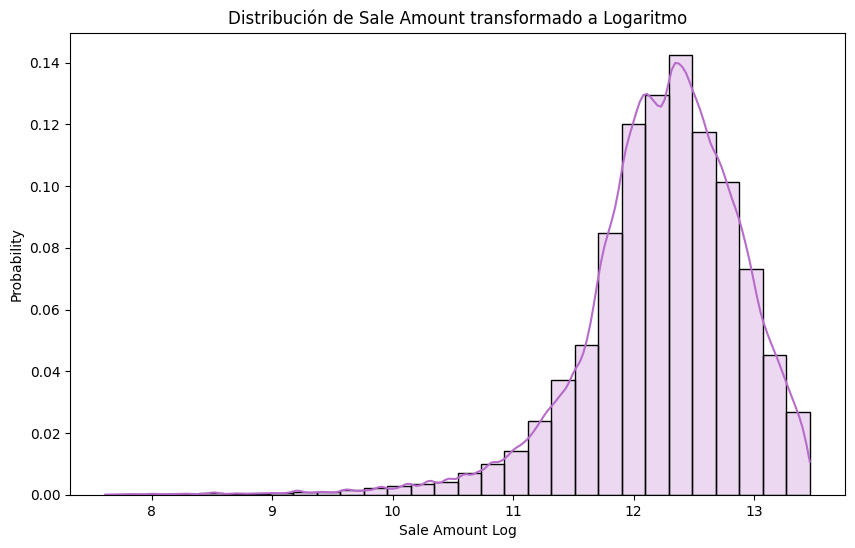

In [26]:
# Primero generamos la variable logarítmica
df['Sale Amount Log'] = np.log(df['Sale Amount'])

# Luego graficamos
plt.figure(figsize=(10, 6))
# Histograma
sns.histplot(data = df,
             x = 'Sale Amount Log',
             bins = 30,
             alpha = 0.25,
             kde = True,
             stat='probability',
             color = '#B76BCB')
plt.title('Distribución de Sale Amount transformado a Logaritmo')

---
## Conclusión:

Al calcular el logaritmo de la variable y graficarlo, podemos observar que la distribución de los valores cambió, generando ahora una pendiente negativa, pero con mayor sesgo que la variable original.

Por lo que utilizaremos la variable original para continuar con el análisis, no la variable logarítmica que calculamos.

---

# Exploración de valores vacíos
A continuación, se evaluará la presencia de valores vacíos en las variables disponibles.

In [27]:
df.isnull().sum()

Serial Number            0
List Year                0
Date Recorded            0
Town                     0
Address                 12
Assessed Value           0
Sale Amount              0
Sales Ratio              0
Property Type       309122
Residential Type    312115
Non Use Code        601332
Assessor Remarks    676209
OPM remarks         758700
Location            614331
Sale Amount Log          0
dtype: int64

Podemos observar que las columnas con nulos, son:

1. Address: dirección (12 nulos)
2. Property Type: tipo de propiedad (309.122 nulos)
3. Residential Type: tipo residencial (312.115 nulos)
4. Non Use Code: código de no uso (601.332 nulos)
5. Assessor Remarks: Observaciones del asesor (676.209 nulos)
6. OPM remarks: Comentario de la operación (758.700 nulos)
7. Location: ubicación (614.331 nulos)

Luego de analizar las columnas, podemos decir que la falta de información en estas columnas es porque no se capturó. Solo reemplazaremos estos nulos con 'No data' para luego poder transformar estas variables categóricas, en numéricas y poderlas utilizar para buscar correlación con la variable target.


In [28]:
# Tratamiento de nulos
# Rellenamos 'Address', 'Property Type', 'Residential Type', 'Non Use Code', 'Assessor Remarks', 'OPM remarks', 'Location' con 'No data'
Sin_Datos = 'No data'
df.loc[df['Address'].isnull(), 'Address'] = Sin_Datos
df.loc[df['Property Type'].isnull(), 'Property Type'] = Sin_Datos
df.loc[df['Residential Type'].isnull(), 'Residential Type'] = Sin_Datos
df.loc[df['Non Use Code'].isnull(), 'Non Use Code'] = Sin_Datos
df.loc[df['Assessor Remarks'].isnull(), 'Assessor Remarks'] = Sin_Datos
df.loc[df['OPM remarks'].isnull(), 'OPM remarks'] = Sin_Datos
df.loc[df['Location'].isnull(), 'Location'] = Sin_Datos

In [29]:
# Verificamos la existencia de nulos en DataFrame
df.isnull().sum()

Serial Number       0
List Year           0
Date Recorded       0
Town                0
Address             0
Assessed Value      0
Sale Amount         0
Sales Ratio         0
Property Type       0
Residential Type    0
Non Use Code        0
Assessor Remarks    0
OPM remarks         0
Location            0
Sale Amount Log     0
dtype: int64

In [30]:
df.head(2)

,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Non Use Code,Assessor Remarks,OPM remarks,Location,Sale Amount Log
1,20002,2020,10/02/2020,Ashford,390 TURNPIKE RD,253000.00,430000.00,0.59,Residential,Single Family,No data,No data,No data,No data,12.97
2,200212,2020,03/09/2021,Avon,5 CHESTNUT DRIVE,130400.00,179900.00,0.72,Residential,Condo,No data,No data,No data,No data,12.10


# MODELO DE ENTRENAMIENTO Y RESULTADOS

### Correlación
Lo próximo que analizaremos es la correlación entre cada variable disponible, y la variable target.
 <br> <br/>
Debido a que no contamos con muchas variables numéricas en el DF, generaremos nuevas variables numéricas a partir de las variables categóricas, para poder analizar la relación con la variable target. Luego procederemos a realizar un análisis más en profundidad de alguna de ellas.

In [31]:
# Generamos nueva variable por medio de la funcion MEAN para poder utilizar dicha variable en el modelo.
Agrupacion_Town = df.groupby('Town')['Sale Amount'].mean().reset_index()
# Renombramos la columna "Sale Amount" por un nombre facil de detectar.
Agrupacion_Town.rename(columns={'Sale Amount': 'Town_mean'}, inplace=True)
Agrupacion_Town

,Town,Town_mean
0,***Unknown***,282450.00
1,Andover,230984.03
2,Ansonia,205066.69
3,Ashford,183312.62
4,Avon,333453.30
...,...,...
165,Windsor Locks,182161.46
166,Wolcott,231947.43
167,Woodbridge,370366.12
168,Woodbury,279959.94


In [32]:
# Fusionsmos (df) con el DataFrame (Agrupacion_Town) utilizando la columna "Town" como clave
df = df.merge(Agrupacion_Town, on='Town', how='left')

In [33]:
# Generamos nueva variable por medio de la funcion MEAN para poder utilizar dicha variable en el modelo.
Agrupacion_Property = df.groupby('Property Type')['Sale Amount'].mean().reset_index()
# Renombramos la columna "Sale Amount" por un nombre facil de detectar.
Agrupacion_Property.rename(columns={'Sale Amount': 'Property_mean'}, inplace=True)
Agrupacion_Property

,Property Type,Property_mean
0,Apartments,351203.44
1,Commercial,297745.78
2,Condo,202147.57
3,Four Family,249364.87
4,Industrial,274310.96
5,No data,235190.21
6,Public Utility,47272.00
7,Residential,286765.60
8,Single Family,267934.88
9,Three Family,207013.37


In [34]:
# Fusionsmos (df) con el DataFrame (Agrupacion_Property) utilizando la columna "Property Type" como clave
df = df.merge(Agrupacion_Property, on='Property Type', how='left')

In [35]:
# Generamos nueva variable por medio de la funcion MEAN para poder utilizar dicha variable en el modelo.
Agrupacion_Residential = df.groupby('Residential Type')['Sale Amount'].mean().reset_index()
# Renombramos la columna "Sale Amount" por un nombre facil de detectar.
Agrupacion_Residential.rename(columns={'Sale Amount': 'Residential_mean'}, inplace=True)
Agrupacion_Residential

,Residential Type,Residential_mean
0,Condo,203704.24
1,Four Family,255235.35
2,No data,234855.49
3,Single Family,272105.22
4,Three Family,213604.91
5,Two Family,214684.27


In [36]:
# Fusionsmos (df) con el DataFrame (Agrupacion_Residential) utilizando la columna "Residential Type" como clave
df = df.merge(Agrupacion_Residential, on='Residential Type', how='left')

In [37]:
df

,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Non Use Code,Assessor Remarks,OPM remarks,Location,Sale Amount Log,Town_mean,Property_mean,Residential_mean
0,20002,2020,10/02/2020,Ashford,390 TURNPIKE RD,253000.00,430000.00,0.59,Residential,Single Family,No data,No data,No data,No data,12.97,183312.62,286765.60,272105.22
1,200212,2020,03/09/2021,Avon,5 CHESTNUT DRIVE,130400.00,179900.00,0.72,Residential,Condo,No data,No data,No data,No data,12.10,333453.30,286765.60,203704.24
2,20139,2020,12/16/2020,Bethel,16 DEEPWOOD DRIVE,171360.00,335000.00,0.51,Residential,Single Family,No data,No data,No data,No data,12.72,324883.98,286765.60,272105.22
3,200086,2020,08/10/2021,Bethlehem,39 WOODLAND RD,168900.00,352000.00,0.48,Residential,Single Family,No data,No data,No data,POINT (-73.18197 41.64672),12.77,276876.66,286765.60,272105.22
4,201295,2020,09/09/2021,Bristol,609 CAMP ST,144340.00,249900.00,0.58,Residential,Single Family,No data,No data,No data,No data,12.43,184840.11,286765.60,272105.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
765745,19921,2019,11/18/2019,West Haven,75 CLOVER ST,125230.00,246000.00,0.51,Single Family,Single Family,No data,No data,No data,POINT (-72.96445 41.25722),12.41,182223.06,267934.88,272105.22
765746,190272,2019,06/24/2020,New London,4 BISHOP CT,60410.00,53100.00,1.14,Single Family,Single Family,14 - Foreclosure,No data,No data,No data,10.88,180566.48,267934.88,272105.22
765747,190284,2019,11/27/2019,Waterbury,126 PERKINS AVE,68280.00,76000.00,0.90,Single Family,Single Family,25 - Other,PRIVATE SALE,No data,No data,11.24,135692.38,267934.88,272105.22
765748,190129,2019,04/27/2020,Windsor Locks,19 HATHAWAY ST,121450.00,210000.00,0.58,Single Family,Single Family,No data,No data,No data,No data,12.25,182161.46,267934.88,272105.22


In [38]:
# Verificamos la existencia de nulos en DataFrame
df.isnull().sum()

Serial Number       0
List Year           0
Date Recorded       0
Town                0
Address             0
Assessed Value      0
Sale Amount         0
Sales Ratio         0
Property Type       0
Residential Type    0
Non Use Code        0
Assessor Remarks    0
OPM remarks         0
Location            0
Sale Amount Log     0
Town_mean           0
Property_mean       0
Residential_mean    0
dtype: int64

In [39]:
print(df.dtypes)

Serial Number         int64
List Year             int64
Date Recorded        object
Town                 object
Address              object
Assessed Value      float64
Sale Amount         float64
Sales Ratio         float64
Property Type        object
Residential Type     object
Non Use Code         object
Assessor Remarks     object
OPM remarks          object
Location             object
Sale Amount Log     float64
Town_mean           float64
Property_mean       float64
Residential_mean    float64
dtype: object


In [40]:
# Convertimos las variables Date Recorded de tipo objet a datetime
df['Date Recorded'] = pd.to_datetime(df['Date Recorded'], format='%m/%d/%Y')


In [41]:
print(df.dtypes)

Serial Number                int64
List Year                    int64
Date Recorded       datetime64[ns]
Town                        object
Address                     object
Assessed Value             float64
Sale Amount                float64
Sales Ratio                float64
Property Type               object
Residential Type            object
Non Use Code                object
Assessor Remarks            object
OPM remarks                 object
Location                    object
Sale Amount Log            float64
Town_mean                  float64
Property_mean              float64
Residential_mean           float64
dtype: object


In [42]:
# Seleccionar solo columnas numéricas
df_numeric = df.select_dtypes(include=['int64', 'float64','datetime64[ns]'])

# Calculo matriz de correlación
matriz_correlacion = df_numeric.corr(method='pearson')
# Selecciono a la variable target para estudiar únicamente correlación con ella
matriz_correlacion_target = matriz_correlacion['Sale Amount']
# Calculo valor absoluto, para extraer correlaciones más fuertes independientemente de su sentido
matriz_correlacion_target = abs(matriz_correlacion_target)
# Menciono columnas que quiero excluir del análisis de correlación
columnas_a_excluir = ['Sale Amount', 'Sale Amount Log']
# Las excluyo del análisis
matriz_correlacion_target = matriz_correlacion_target.drop(columns=columnas_a_excluir, index=columnas_a_excluir)
# Ordeno de mayor a menor correlación
matriz_correlacion_target = matriz_correlacion_target.sort_values(ascending=False)

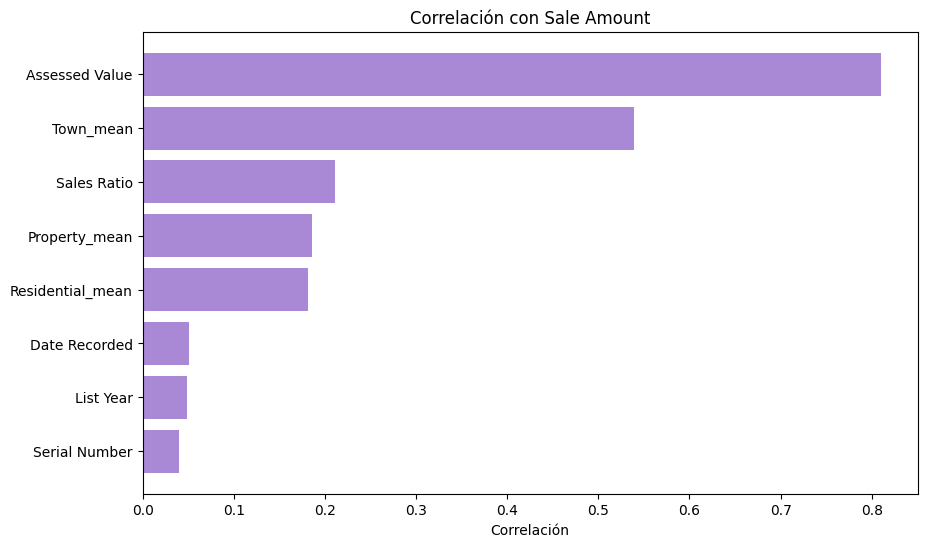

In [43]:
# Grafico las variables y su correlación con la variable target
plt.figure(figsize=(10, 6))  # Tamaño de la figura
plt.barh(matriz_correlacion_target.index,
         matriz_correlacion_target.values,
         color = '#A989D6')
plt.xlabel('Correlación')
plt.title('Correlación con Sale Amount')
plt.gca().invert_yaxis()  # Invertir el eje Y para mostrar la característica más relevante en la parte superior
plt.show()

### Analizando la variable "Assessed Value": Análisis Univariado


Text(0.5, 1.0, 'Distribución de Assessed Value')

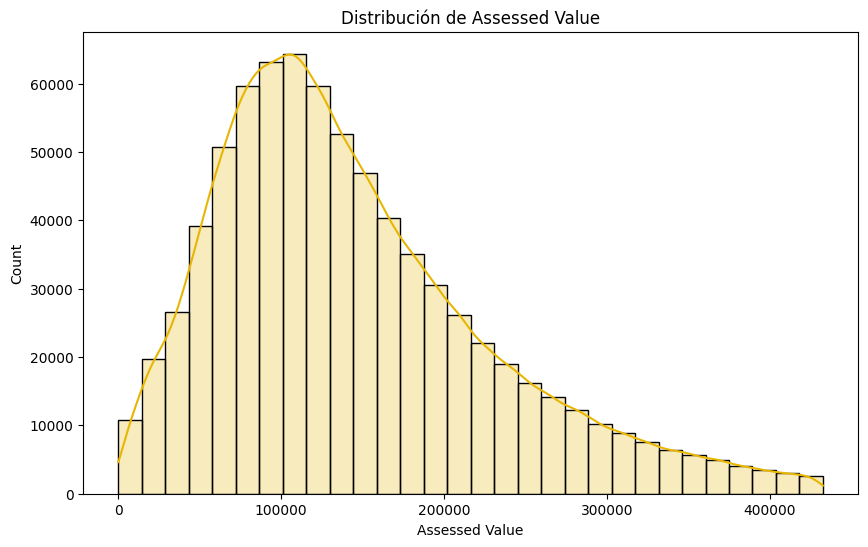

In [44]:
# Cantidad de ventas por precio de tasación
plt.figure(figsize=(10, 6))  # Tamaño de la figura
# Histograma
sns.histplot(data = df,
             x = 'Assessed Value',
             bins = 30,
             alpha = 0.25,
             kde = True,
             color = '#E7B602')
plt.title('Distribución de Assessed Value')

---
Podemos observar que la mayor cantidad de registros se encuentran entre los valores de tasación que van desde los 50.000 a 200.000 dólares..

---

### Analizando la variable "Assessed Value": Análisis Bivariado
Objetivo final: Predecir precio de venta de una casa.

Lo próximo que haremos es ver cómo es la relación de esta variable con nuestro target.

Variable dependiente: "Sale Amount"

Variable independiente: "Assessed Value"


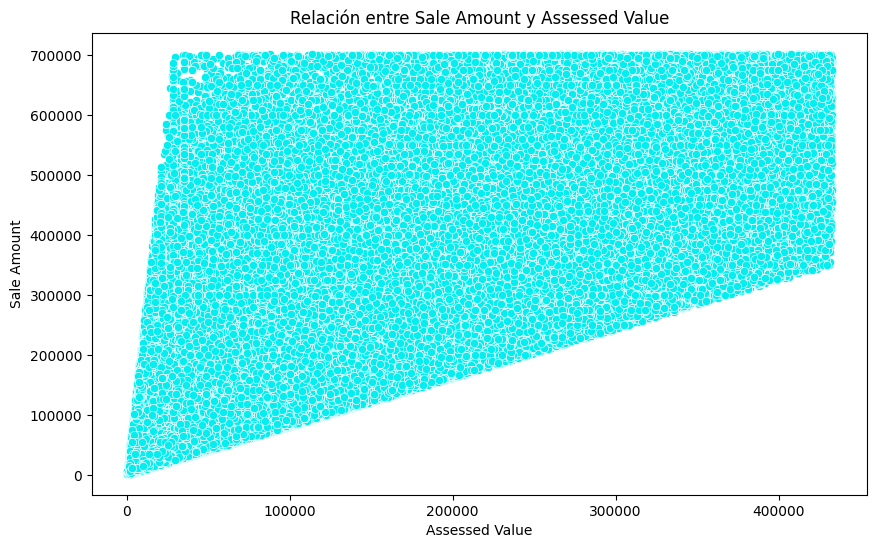

In [45]:
# Visualmente Variable independiente "Assessed Value" y su relacion con Sale Amount

plt.figure(figsize=(10, 6))
sns.scatterplot(data = df,
                x = 'Assessed Value',
                y = 'Sale Amount',
               color = '#06EDF0')
plt.xlabel('Assessed Value')
plt.ylabel('Sale Amount')
plt.title('Relación entre Sale Amount y Assessed Value')
plt.ticklabel_format(style='plain', axis='y')
plt.ticklabel_format(style='plain', axis='x')

---
Se detecta una relación positiva entre las variables analizadas ya que, a medida que Assessed Value aumenta, Sale Amount también aumenta.


---


### Analizamos la variable "Town_mean":  Análisis Univariado
Objetivo final: Predecir precio de venta de una casa.

Variable independiente: "Town_mean"

Text(0.5, 1.0, 'Distribución de Town_mean')

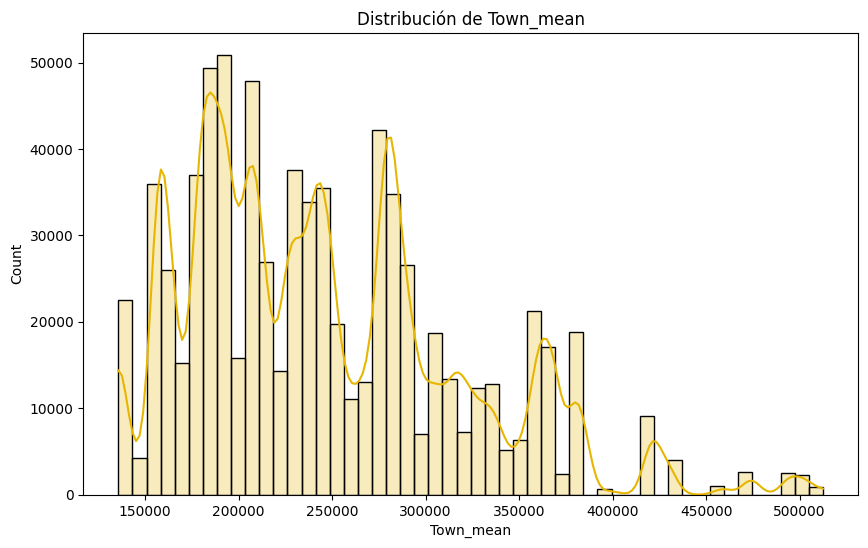

In [46]:
# Cantidad de ventas por ciudad
plt.figure(figsize=(10, 6))  # Tamaño de la figura
# Histograma
sns.histplot(data = df,
             x = 'Town_mean',
             bins = 50,
             alpha = 0.25,
             kde = True,
             color = '#E7B602')
plt.title('Distribución de Town_mean')

---
Podemos observar que a medida que la media calculada para nuestra columna TOWN aumenta, la cantidad de registros disminuye.
Lo que nos da un indicio de que la mayor cantidad de registros se encuentra en los valores bajos de ventas, quedando pocas ventas en valores altos.

---

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Danbury'),
  Text(1, 0, 'Hartford'),
  Text(2, 0, 'Milford'),
  Text(3, 0, 'Norwalk'),
  Text(4, 0, 'Meriden'),
  Text(5, 0, 'New Haven'),
  Text(6, 0, 'Stamford'),
  Text(7, 0, 'West Hartford'),
  Text(8, 0, 'Waterbury'),
  Text(9, 0, 'Bridgeport')])

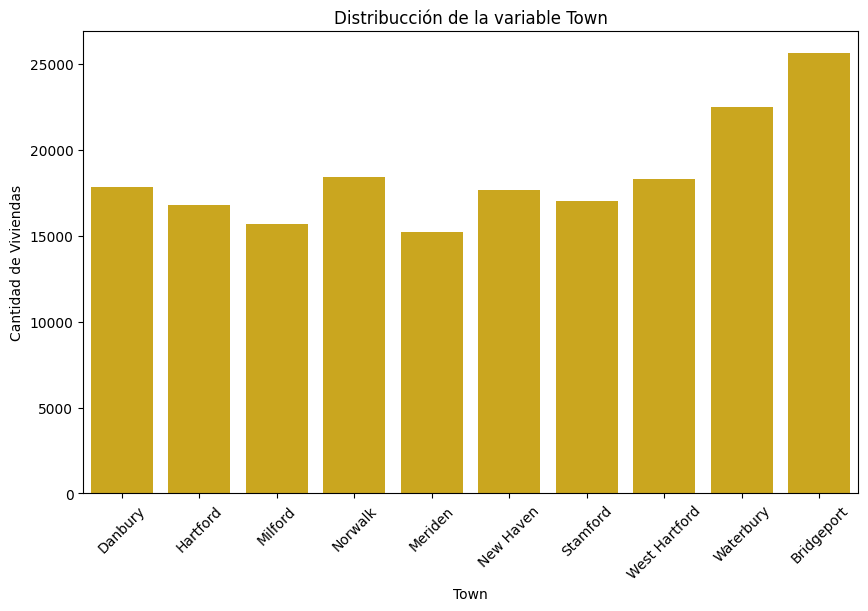

In [47]:
# Cantidad de ventas por las principales 10 Ciudades.
# Para este análisis utilizaremos la variable original Town.
top_cities1 = df['Town'].value_counts().nlargest(10) # Primero, obtén los 10 principales valores de 'Town' en términos de la cantidad de casos
df_top_cities1 = df[df['Town'].isin(top_cities1.index)] # Luego, crea un subconjunto del DataFrame original con solo las filas que corresponden a las 10 principales ciudades

plt.figure(figsize=(10, 6))  # Tamaño de la figura
sns.countplot(data = df_top_cities1,
              x = 'Town',
             color = '#E7B602')
plt.title('Distribucción de la variable Town')
plt.ylabel('Cantidad de Viviendas')
plt.xticks(rotation=45)

---
Observamos que la mayor cantidad de ventas se encuentras registradas en la ciudad de Bridgeport, con aproximadamente 25.000 ventas.

---

### Analizamos la variable "Town_mean":  Análisis Bivariado
Objetivo final: Predecir precio de venta de una casa.

Variable dependiente: "Sale Amount"

Variable independiente: "Town_mean"


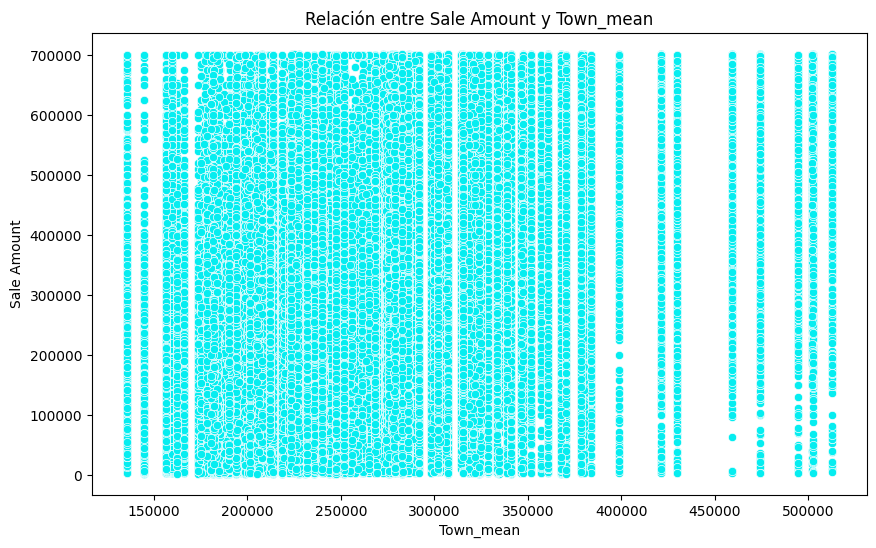

In [48]:
# Visualmente Variable independiente "Town_mean" y su relacion con Sale Amount

plt.figure(figsize=(10, 6))
sns.scatterplot(data = df,
                x = 'Town_mean',
                y = 'Sale Amount',
               color = '#06EDF0')
plt.xlabel('Town_mean')
plt.ylabel('Sale Amount')
plt.title('Relación entre Sale Amount y Town_mean')
plt.ticklabel_format(style='plain', axis='y')
plt.ticklabel_format(style='plain', axis='x')

---
No se encuentra una relación marcada entre Town_mean y Sale Amount. Solo podemos detectar que la mayor cantidad de registros se encuentra entre los valores de 180.000 y 350.000 de la variable Town_mean

Aplicaremos un top 10 en este caso también, para poder visualizar una relación entre Sale Amount y las principales 10 ciudades.

---



(array([100000., 150000., 200000., 250000., 300000., 350000., 400000.]),
 [Text(100000.0, 0, '100000'),
  Text(150000.0, 0, '150000'),
  Text(200000.0, 0, '200000'),
  Text(250000.0, 0, '250000'),
  Text(300000.0, 0, '300000'),
  Text(350000.0, 0, '350000'),
  Text(400000.0, 0, '400000')])

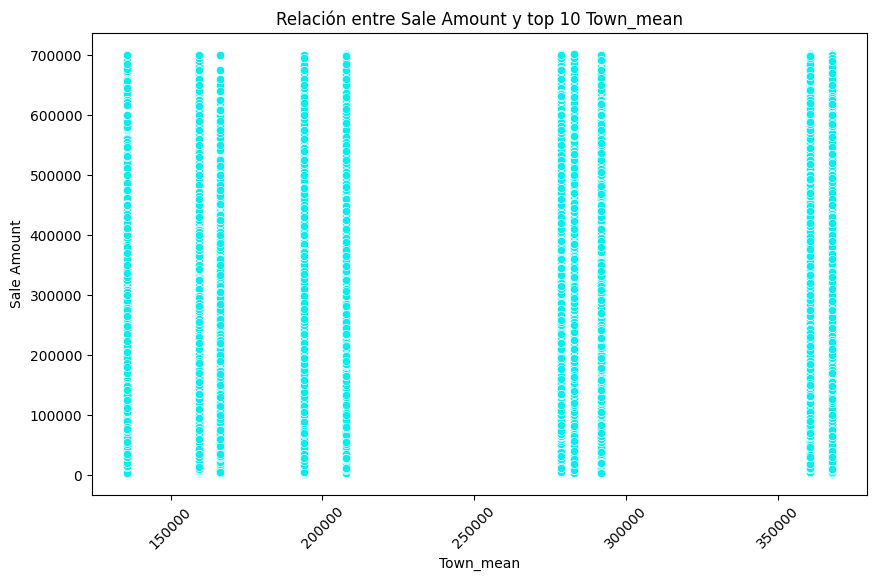

In [49]:
# Cantidad de ventas por las principales 10 Ciudades.
# Para este análisis utilizaremos la variable Town_mean.
top_cities2 = df['Town_mean'].value_counts().nlargest(10) # Primero, obtén los 10 principales valores de 'Town_mean' en términos de la cantidad de casos
df_top_cities2 = df[df['Town_mean'].isin(top_cities2.index)] # Luego, crea un subconjunto del DataFrame original con solo las filas que corresponden a las 10 principales ciudades

plt.figure(figsize=(10, 6))
sns.scatterplot(data = df_top_cities2,
                x = 'Town_mean',
                y = 'Sale Amount',
               color = '#06EDF0')
plt.xlabel('Town_mean')
plt.ylabel('Sale Amount')
plt.title('Relación entre Sale Amount y top 10 Town_mean')
plt.ticklabel_format(style='plain', axis='y')
plt.ticklabel_format(style='plain', axis='x')
plt.xticks(rotation=45)

---
No se encuentra una relación marcada entre las principales 10 ciudades (representadas por la columna Town_mean) y Sale Amount.

---

### Analizando la variable "Sales Ratio": Análisis Univariado


Text(0.5, 1.0, 'Distribución de Sales Ratio')

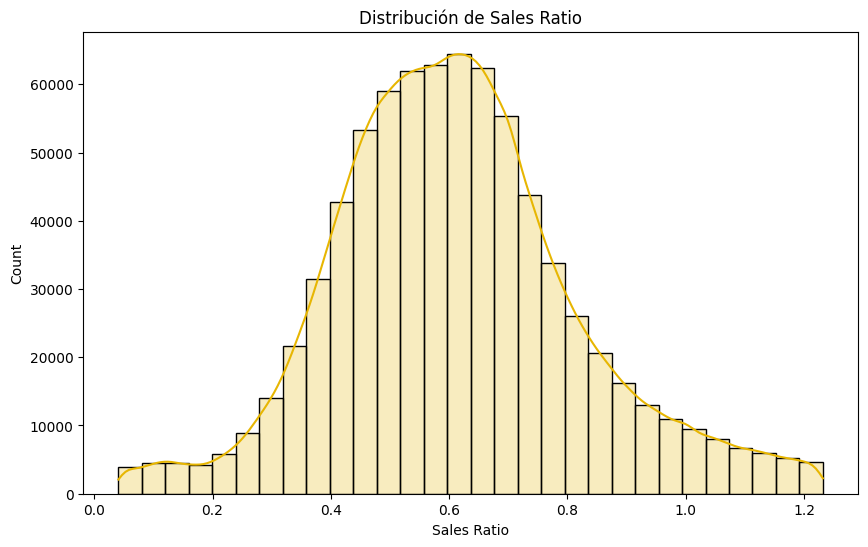

In [50]:
# Cantidad de ventas por Sales Ratio
plt.figure(figsize=(10, 6))  # Tamaño de la figura
# Histograma
sns.histplot(data = df,
             x = 'Sales Ratio',
             bins = 30,
             alpha = 0.25,
             kde = True,
             color = '#E7B602')
plt.title('Distribución de Sales Ratio')

---
Podemos observar que la mayor cantidad de registros se encuentran entre 0.4 Y 0.8 de la variable Sales Ratio. Esto significa que la mayor cantidad de ventas fueron concretadas con precio de venta de entre un 40 % a un 80 % mayor, respecto del valor de tasación.

En este caso la distribución de la variable la podemos considerar como NORMAL.

---

### Analizando la variable "Sales Ratio": Análisis Bivariado
Objetivo final: Predecir precio de venta de una casa.

Lo próximo que haremos es ver cómo es la relación de esta variable con nuestro target.

Variable dependiente: "Sale Amount"

Variable independiente: "Sales Ratio"


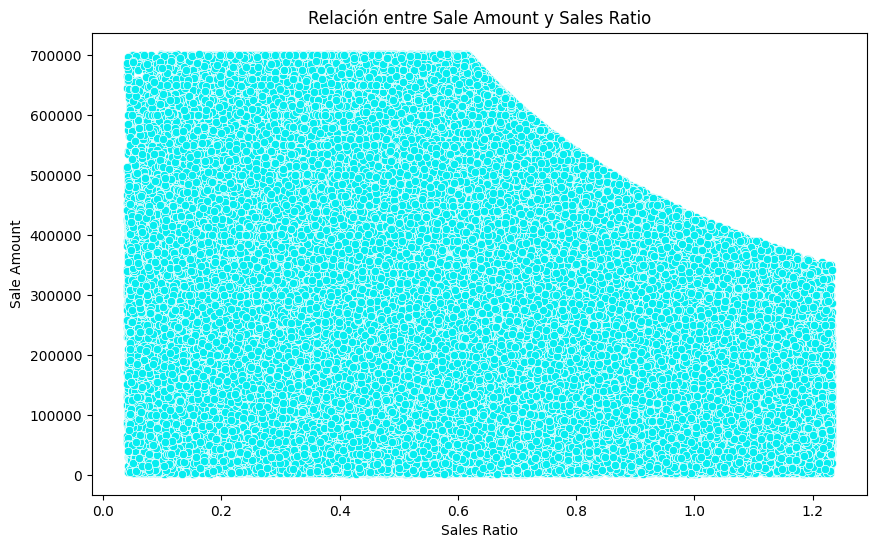

In [51]:
# Visualmente Variable independiente "Sales Ratio" y su relacion con Sale Amount

plt.figure(figsize=(10, 6))
sns.scatterplot(data = df,
                x = 'Sales Ratio',
                y = 'Sale Amount',
               color = '#06EDF0')
plt.xlabel('Sales Ratio')
plt.ylabel('Sale Amount')
plt.title('Relación entre Sale Amount y Sales Ratio')
plt.ticklabel_format(style='plain', axis='y')
plt.ticklabel_format(style='plain', axis='x')

---
Se detecta una relación negativa entre las variables analizadas, debido a que a medida que aumenta la variable Sales Ratio, disminuye la variable Sale Amount.

Observamos que las propiedades que se vendieron a un precio de hasta 700.000 dólares aproximadamente, pueden tener un ratio de hasta 0.6 aproximadamente.
A partir de este punto el ratio continúa aumentando, pero el precio de venta comienza a disminuir hasta llegar a un precio de venta de 350.000 dólares aproximadamente.

En conclución las ventas con mayor ratio, son aquellas que se ubican entre los 2.000 y 350.000 dólares.

---


### Analizamos la variable "Property_mean":  Análisis Univariado
Objetivo final: Predecir precio de venta de una casa.

Variable independiente: "Property_mean"

Text(0.5, 1.0, 'Distribución de Property_mean')

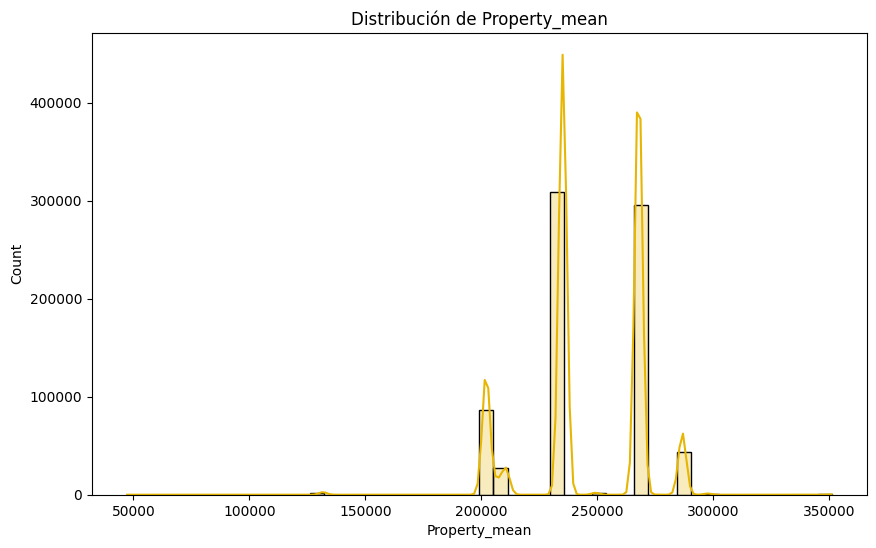

In [52]:
# Cantidad de ventas por tipo de propiedad
plt.figure(figsize=(10, 6))  # Tamaño de la figura
# Histograma
sns.histplot(data = df,
             x = 'Property_mean',
             bins = 50,
             alpha = 0.25,
             kde = True,
             color = '#E7B602')
plt.title('Distribución de Property_mean')

---
Podemos observar que la mayor cantidad de registros se encuentra en los tipos de propiedades cuya media se encuentra entre 200.000 y los 300.000 dólares.

Esto nos da un indicio que la mayor cantidad de ventas se encuentra 5 tipos de propiedades.

Pasaremos a analizar cuáles son dichos tipos de propiedades.

---

([0, 1, 2, 3, 4],
 [Text(0, 0, 'Residential'),
  Text(1, 0, 'No data'),
  Text(2, 0, 'Condo'),
  Text(3, 0, 'Two Family'),
  Text(4, 0, 'Single Family')])

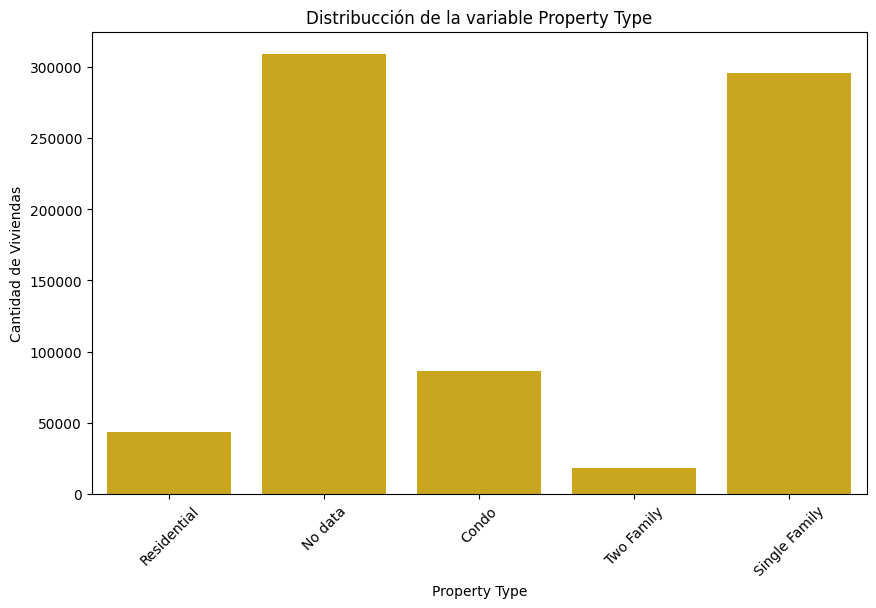

In [53]:
# Cantidad de ventas por los principales 5 tipos de propiedad
# Para este analisis utilizaremos la variable original Property Type.
top_property = df['Property Type'].value_counts().nlargest(5) # Primero, obtenemos los 5 principales valores de 'Property Type' en términos de la cantidad de casos
df_top_property = df[df['Property Type'].isin(top_property.index)] # Luego, creamos un subconjunto del DataFrame original con solo las filas que corresponden a las 5 principales tipos de propiedades

plt.figure(figsize=(10, 6))  # Tamaño de la figura
sns.countplot(data = df_top_property,
              x = 'Property Type',
             color = '#E7B602')
plt.title('Distribucción de la variable Property Type')
plt.ylabel('Cantidad de Viviendas')
plt.xticks(rotation=45)

---
Observamos que la mayor cantidad de ventas se encuentran sin datos (más de 300.000) en el tipo de propiedad, en segundo lugar se encuentran los tipo "Single Family" (entre 250.000 y 300.000 ventas) y tercer lugar los tipo "Condo" (mas de 50.000 y menos de 100.000 ventas aproximadamente).

---


### Analizamos la variable "Property_mean":  Análisis Bivariado
Objetivo final: Predecir precio de venta de una casa.

Variable dependiente: "Sale Amount"

Variable independiente: "Property_mean"


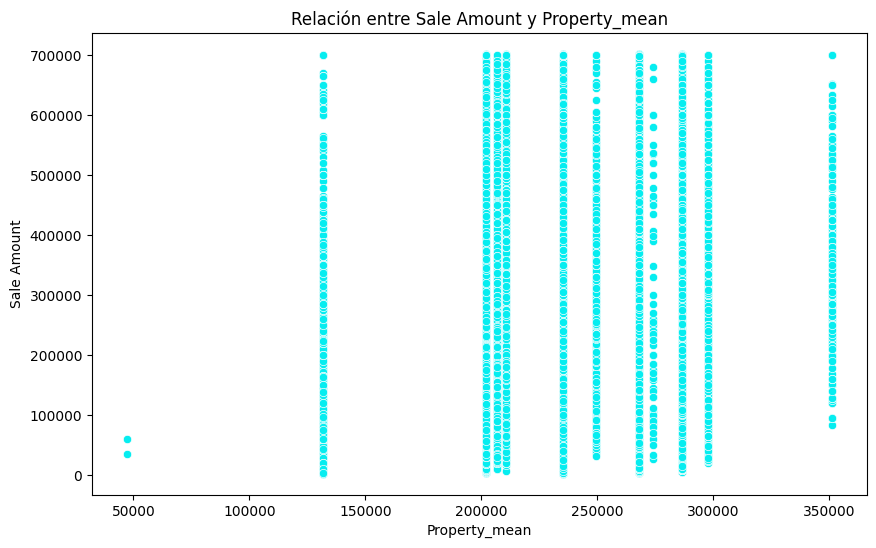

In [54]:
# Visualmente Variable independiente "Property_mean" y su relacion con Sale Amount

plt.figure(figsize=(10, 6))
sns.scatterplot(data = df,
                x = 'Property_mean',
                y = 'Sale Amount',
               color = '#06EDF0')
plt.xlabel('Property_mean')
plt.ylabel('Sale Amount')
plt.title('Relación entre Sale Amount y Property_mean')
plt.ticklabel_format(style='plain', axis='y')
plt.ticklabel_format(style='plain', axis='x')

---
No se encuentra una relación marcada entre Property_mean y Sale Amount.

Aplicaremos un top 5 en este caso también, para poder visualizar una relación entre Sale Amount y las principales 5 tipos de propiedades.

---



(array([180000., 200000., 220000., 240000., 260000., 280000., 300000.]),
 [Text(180000.0, 0, '180000'),
  Text(200000.0, 0, '200000'),
  Text(220000.0, 0, '220000'),
  Text(240000.0, 0, '240000'),
  Text(260000.0, 0, '260000'),
  Text(280000.0, 0, '280000'),
  Text(300000.0, 0, '300000')])

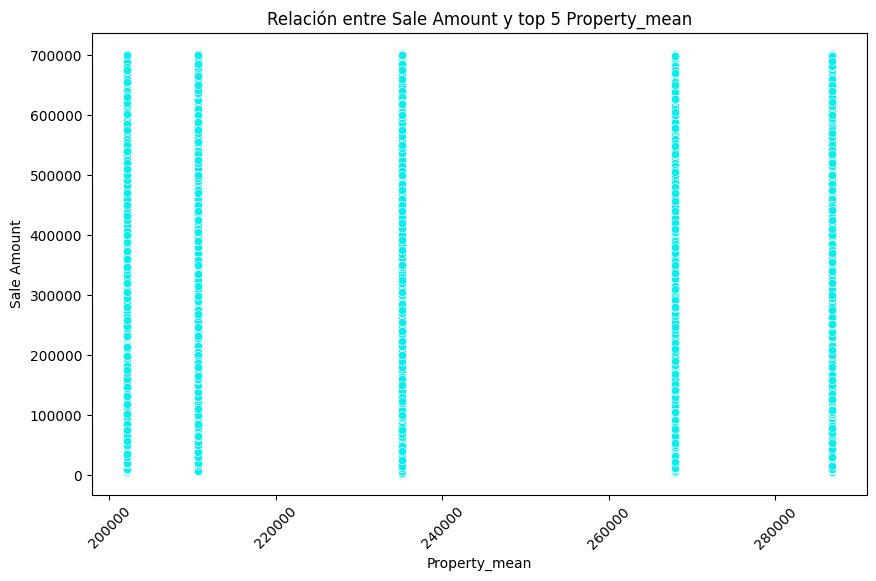

In [55]:
# Cantidad de ventas por las principales 5 tipos de propiedad.
# Para este análisis utilizaremos la variable Property_mean .
top_property1 = df['Property_mean'].value_counts().nlargest(5) # Primero, obtén los 5 principales valores de 'Property_mean ' en términos de la cantidad de casos
df_top_property1 = df[df['Property_mean'].isin(top_property1.index)] # Luego, crea un subconjunto del DataFrame original con solo las filas que corresponden a las 5 principales tipos de propiedad

plt.figure(figsize=(10, 6))
sns.scatterplot(data = df_top_property1,
                x = 'Property_mean',
                y = 'Sale Amount',
               color = '#06EDF0')
plt.xlabel('Property_mean')
plt.ylabel('Sale Amount')
plt.title('Relación entre Sale Amount y top 5 Property_mean')
plt.ticklabel_format(style='plain', axis='y')
plt.ticklabel_format(style='plain', axis='x')
plt.xticks(rotation=45)

---
No se encuentra una relación marcada entre los principales 5 tipos de propiedad (representadas por la columna Property_mean) y Sale Amount.

---

### Analizamos la variable "Residential_mean":  Análisis Univariado
Objetivo final: Predecir precio de venta de una casa.

Variable independiente: "Residential_mean"

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Single Family'),
  Text(1, 0, 'Condo'),
  Text(2, 0, 'Two Family'),
  Text(3, 0, 'No data'),
  Text(4, 0, 'Three Family'),
  Text(5, 0, 'Four Family')])

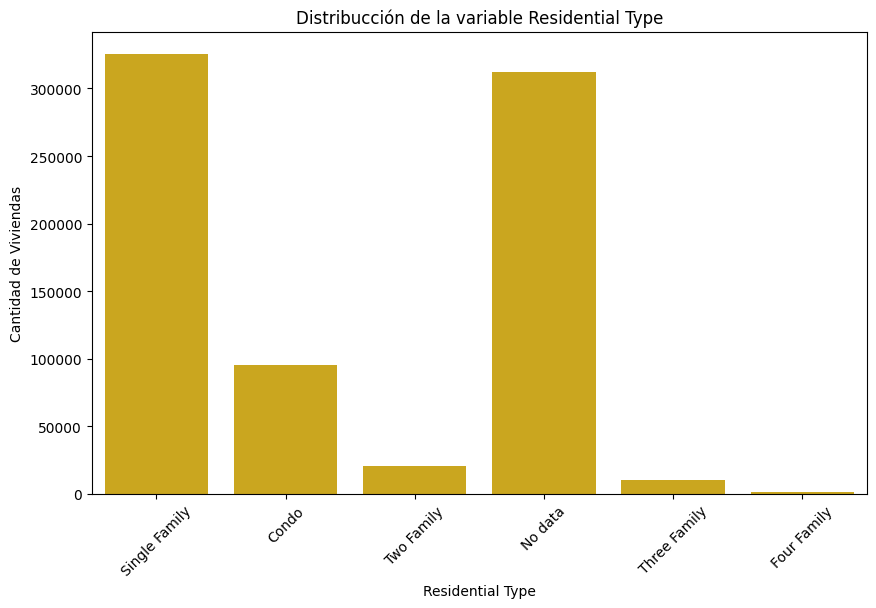

In [56]:
# Cantidad de ventas por tipo de residencia
plt.figure(figsize=(10, 6))
sns.countplot(data = df,
              x = 'Residential Type',
             color = '#E7B602')
plt.title('Distribucción de la variable Residential Type')
plt.ylabel('Cantidad de Viviendas')
plt.xticks(rotation=45)

---

Podemos observar que la mayor cantidad de registros se encuentra en 3 tipos de residencia principalmente.


Observamos que la mayor cantidad de ventas se pertenecen a los tipos de residencia Single Family (más de 300.000), en segundo lugar los registros sin datos (entre 250.000 y 300.000) y tercer lugar los tipo Condo (alrededor de 70.000).

---

### Analizamos la variable "Residential_mean":  Análisis Bivariado
Objetivo final: Predecir precio de venta de una casa.

Variable dependiente: "Sale Amount"

Variable independiente: "Residential_mean"


([0, 1, 2, 3, 4, 5],
 [Text(0, 0, '203704.23905429163'),
  Text(1, 0, '213604.9087532624'),
  Text(2, 0, '214684.27182484904'),
  Text(3, 0, '234855.488928568'),
  Text(4, 0, '255235.34672435105'),
  Text(5, 0, '272105.21856237814')])

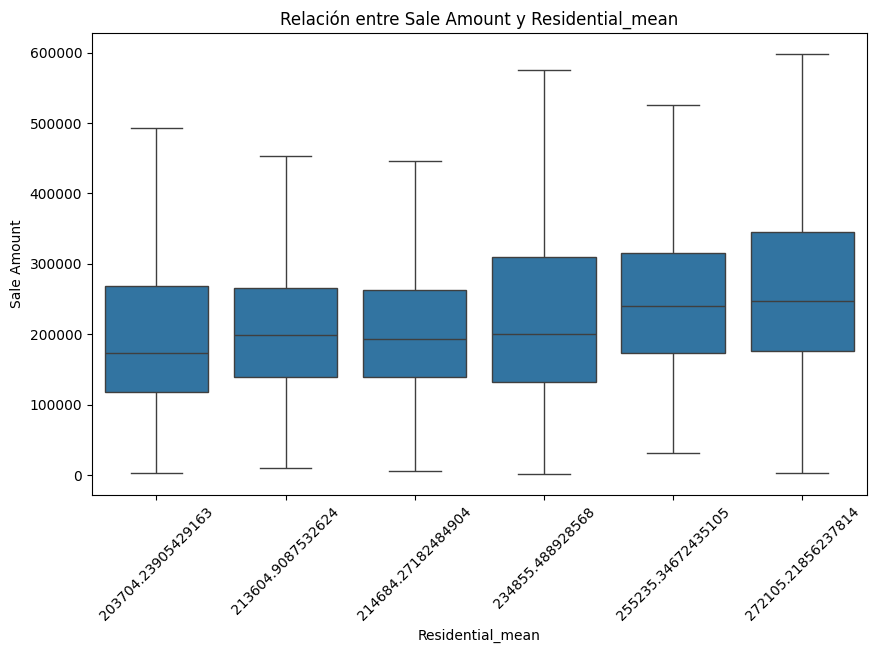

In [57]:
# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data = df,
            x = 'Residential_mean',
            y = 'Sale Amount',
            showfliers = False)
plt.title('Relación entre Sale Amount y Residential_mean')
plt.xticks(rotation=45)

---

Se observa una pequeña relación positiva entre las variables analizadas, ya que a medida que aumenta la variable Residential_mean, también aumenta la variable Sale Amount.

---


# Metodo one-hot encoding

Vamos a utilizar el metodo one-hot encoding para incorporar algunas variables categóricas a nuestro modelo de regresión lineal.

Variables categóricas:




In [58]:
features_categoricas = df.select_dtypes(include=['object'])
features_categoricas.columns

Index(['Town', 'Address', 'Property Type', 'Residential Type', 'Non Use Code',
       'Assessor Remarks', 'OPM remarks', 'Location'],
      dtype='object')

In [59]:
# Cuántos valores distintos tiene cada categoría?
valores_distintos = features_categoricas.nunique()
print(valores_distintos.sort_values(ascending=False))

Address             572708
Location            104103
Assessor Remarks     41080
OPM remarks           3539
Town                   170
Non Use Code            72
Property Type           12
Residential Type         6
dtype: int64


De todas estas variables solo nos quedan disponibles las siguientes:

* Para estas 4 variables utilizaremos otro método:
  * Address   -     Valores distintos:     572708
  * Location    -   Valores distintos:       104103
  * Assessor Remarks - Valores distintos:    41080
  * OPM remarks    -   Valores distintos:     3539


* La variable "Date Recorded" no la utilizaremos para crear una nueva variable por tiene una relacion directa con la variable a predecir.

* Por más que vemos que la variable Non Use Code tiene muchos registros distintos y que se nos generarían multiples nuevas columnas, la utilizaremos y veremos resultados:

  * Non Use Code   -    Valores distintos:      72



In [60]:
# Agrupamos para analisar informacion
Agrupacion_Non_Use_Code = df.groupby('Non Use Code')
Agrupacion_Non_Use_Code

In [61]:
conteo_por_grupo = Agrupacion_Non_Use_Code.size()
conteo_ordenado = conteo_por_grupo.sort_values(ascending=False)
print(conteo_ordenado)

Non Use Code
No data                    601332
25 - Other                  34458
14 - Foreclosure            29161
07 - Change in Property     23210
7                           16979
                            ...  
55                              1
20                              1
68                              1
74                              1
88                              1
Length: 72, dtype: int64


In [62]:
#Creando variables dummy "Non Use Code"
df = pd.get_dummies(df, columns=['Non Use Code'])
df = df.replace({True: 1, False: 0})
df

,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,...,Non Use Code_6,Non Use Code_68,Non Use Code_7,Non Use Code_73,Non Use Code_74,Non Use Code_8,Non Use Code_88,Non Use Code_9,Non Use Code_No data,Non Use Code_Single Family
0,20002,2020,2020-10-02,Ashford,390 TURNPIKE RD,253000.00,430000.00,0.59,Residential,Single Family,...,0,0,0,0,0,0,0,0,1,0
1,200212,2020,2021-03-09,Avon,5 CHESTNUT DRIVE,130400.00,179900.00,0.72,Residential,Condo,...,0,0,0,0,0,0,0,0,1,0
2,20139,2020,2020-12-16,Bethel,16 DEEPWOOD DRIVE,171360.00,335000.00,0.51,Residential,Single Family,...,0,0,0,0,0,0,0,0,1,0
3,200086,2020,2021-08-10,Bethlehem,39 WOODLAND RD,168900.00,352000.00,0.48,Residential,Single Family,...,0,0,0,0,0,0,0,0,1,0
4,201295,2020,2021-09-09,Bristol,609 CAMP ST,144340.00,249900.00,0.58,Residential,Single Family,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
765745,19921,2019,2019-11-18,West Haven,75 CLOVER ST,125230.00,246000.00,0.51,Single Family,Single Family,...,0,0,0,0,0,0,0,0,1,0
765746,190272,2019,2020-06-24,New London,4 BISHOP CT,60410.00,53100.00,1.14,Single Family,Single Family,...,0,0,0,0,0,0,0,0,0,0
765747,190284,2019,2019-11-27,Waterbury,126 PERKINS AVE,68280.00,76000.00,0.90,Single Family,Single Family,...,0,0,0,0,0,0,0,0,0,0
765748,190129,2019,2020-04-27,Windsor Locks,19 HATHAWAY ST,121450.00,210000.00,0.58,Single Family,Single Family,...,0,0,0,0,0,0,0,0,1,0


En la columna 'Non Use Code' puede ser útil el método que estamos utilizando ya que dicho código puede repetirse en varios registros. En este caso se generar 70 columnas adicionales aproximadamente. Esto no es bueno para nuestro modelo, por lo que, si queremos utilizar este método, deberíamos primero agrupar los registros de la variable 'Non Use Code'. Como podemos observar algunos códigos se utilizan en 1 o pocos registros de ventas, agrupándolos podríamos disminuir la cantidad de registros distintos en esa columna. Esto nos daría como resultado la generación de menos columnas adicionales.

No creo conveniente utilizar este método para los demás campos categóricos debido a que cada venta tiene un registro particular para cada columna. Esto me generaría miles de columnas adicionales (1 columna por registro).

Por lo que las variables de dirección, ubicación, observaciones y comentarios las incorporaremos al modelo solo teniendo en cuenta si tienen registro o no en el dataset.


# Creando nuevos campos

Crearemos algunos campos nuevos para luego incluirlos en nuestro modelo de regresión.

1) Vamos a generar 4 nuevas columnas que harán referencia a:

* Address: dirección (si el registro tiene dirección = 1, si el registro no tiene dirección = 0)
* Location: ubicación (si el registro tiene ubicación = 1, si el registro no tiene ubicación = 0)
* Assessor Remarks: Observaciones del asesor (si el registro tiene observaciones = 1, si el registro no tiene observaciones = 0)
* OPM remarks: Comentario de la operación (si el registro tiene comentarios = 1, si el registro no tiene comentarios = 0)

Al tratar los nulos en el Dataset los registros nulos los reemplazamos como 'No data'. Tomaremos ese dato para reemplazar los 'No data' = 0 y el resto de los registros = 1.


In [63]:
# 1) Vamos a generar 4 nuevas columnas.
df['Address_SI_NO'] = df['Address'].apply(lambda x: 0 if x == 'No data' else 1)
df['Location_SI_NO'] = df['Location'].apply(lambda x: 0 if x == 'No data' else 1)
df['Assessor Remarks_SI_NO'] = df['Assessor Remarks'].apply(lambda x: 0 if x == 'No data' else 1)
df['OPM remarks_SI_NO'] = df['OPM remarks'].apply(lambda x: 0 if x == 'No data' else 1)
df

,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,...,Non Use Code_74,Non Use Code_8,Non Use Code_88,Non Use Code_9,Non Use Code_No data,Non Use Code_Single Family,Address_SI_NO,Location_SI_NO,Assessor Remarks_SI_NO,OPM remarks_SI_NO
0,20002,2020,2020-10-02,Ashford,390 TURNPIKE RD,253000.00,430000.00,0.59,Residential,Single Family,...,0,0,0,0,1,0,1,0,0,0
1,200212,2020,2021-03-09,Avon,5 CHESTNUT DRIVE,130400.00,179900.00,0.72,Residential,Condo,...,0,0,0,0,1,0,1,0,0,0
2,20139,2020,2020-12-16,Bethel,16 DEEPWOOD DRIVE,171360.00,335000.00,0.51,Residential,Single Family,...,0,0,0,0,1,0,1,0,0,0
3,200086,2020,2021-08-10,Bethlehem,39 WOODLAND RD,168900.00,352000.00,0.48,Residential,Single Family,...,0,0,0,0,1,0,1,1,0,0
4,201295,2020,2021-09-09,Bristol,609 CAMP ST,144340.00,249900.00,0.58,Residential,Single Family,...,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
765745,19921,2019,2019-11-18,West Haven,75 CLOVER ST,125230.00,246000.00,0.51,Single Family,Single Family,...,0,0,0,0,1,0,1,1,0,0
765746,190272,2019,2020-06-24,New London,4 BISHOP CT,60410.00,53100.00,1.14,Single Family,Single Family,...,0,0,0,0,0,0,1,0,0,0
765747,190284,2019,2019-11-27,Waterbury,126 PERKINS AVE,68280.00,76000.00,0.90,Single Family,Single Family,...,0,0,0,0,0,0,1,0,1,0
765748,190129,2019,2020-04-27,Windsor Locks,19 HATHAWAY ST,121450.00,210000.00,0.58,Single Family,Single Family,...,0,0,0,0,1,0,1,0,0,0


# TRAIN Y TEST

In [64]:
cantidad_registros = df.shape[0]
semilla = 22
np.random.seed(semilla)
serie_random = np.random.rand(cantidad_registros)
df.loc[:, 'TRAIN'] = np.where(serie_random < 0.3, 0, 1)

In [65]:
# Cómo quedó la división??
resumen = df.groupby('TRAIN').agg(
    Cant = ('Sale Amount', 'count'),
    Media_Precio_Venta = ('Sale Amount', 'mean')
).reset_index()
resumen

,TRAIN,Cant,Media_Precio_Venta
0,0,229874,246196.67
1,1,535876,245952.25


In [66]:
# Validamos información con más pasos
#Filtra el DataFrame = 1 y calculamos Media
filtro = df.loc[df['TRAIN'] == 1]

# Calcula la media de la columna filtrada
media = filtro['Sale Amount'].mean()
media

245952.24600594162

In [67]:
# Filtra el DataFrame = 0 y calculamos Media
filtro1 = df.loc[df['TRAIN'] == 0]

# Calcula la media de la columna filtrada
media1 = filtro1['Sale Amount'].mean()
media1

246196.67226036877

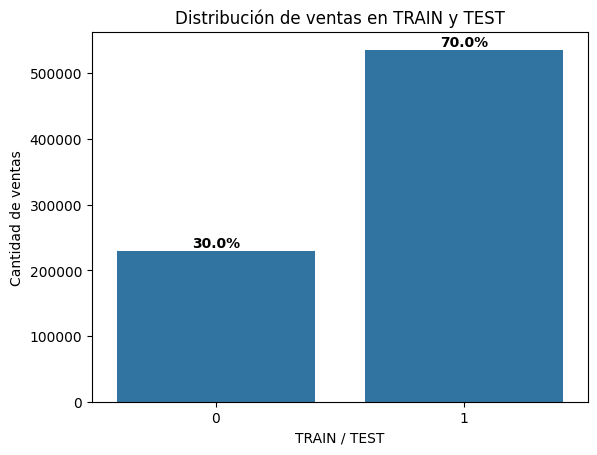

In [68]:
cantidad = len(df['Sale Amount'])

sns.countplot(data = df,
              x = "TRAIN")
plt.xlabel('TRAIN / TEST')
plt.ylabel('Cantidad de ventas')
plt.title('Distribución de ventas en TRAIN y TEST')
ax = plt.gca()
for p in ax.patches:
    x_text = p.get_x() + p.get_width() / 2.0  # Calcula la posición x del texto
    y_text = p.get_height()  # Toma la altura de la columna
    ax.text(x_text, y_text, f'{str(round(int(y_text)/cantidad,2) * 100)}%', # Indica posición x e y, y texto a mostrar
            ha = 'center', # Alineación horizontal
            va = 'bottom',  # Alineación vertical
            fontsize = 10, color = 'black', fontweight = 'bold')
plt.show()

Text(0.5, 1.0, '¿Es el promedio de las ventas igual en ambas subporciones de la muestra?')

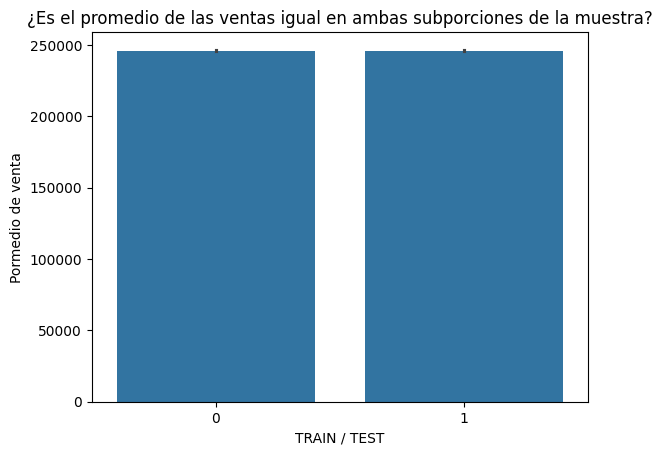

In [69]:
sns.barplot(data = df,
                x = 'TRAIN',
                y = 'Sale Amount')
plt.xlabel('TRAIN / TEST')
plt.ylabel('Pormedio de venta')
plt.title('¿Es el promedio de las ventas igual en ambas subporciones de la muestra?')

In [70]:
df.shape

(765750, 94)

In [71]:
#Generamos nuestro DF_TEST
DF_TEST = df.loc[df['TRAIN'] == 0]
DF_TEST

,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,...,Non Use Code_8,Non Use Code_88,Non Use Code_9,Non Use Code_No data,Non Use Code_Single Family,Address_SI_NO,Location_SI_NO,Assessor Remarks_SI_NO,OPM remarks_SI_NO,TRAIN
0,20002,2020,2020-10-02,Ashford,390 TURNPIKE RD,253000.00,430000.00,0.59,Residential,Single Family,...,0,0,0,1,0,1,0,0,0,0
4,201295,2020,2021-09-09,Bristol,609 CAMP ST,144340.00,249900.00,0.58,Residential,Single Family,...,0,0,0,1,0,1,0,0,0,0
6,200354,2020,2020-12-29,Bristol,391 TIFFANY LA,173740.00,299000.00,0.58,Residential,Single Family,...,0,0,0,1,0,1,0,0,0,0
8,201212,2020,2021-08-23,Bristol,8 JENNINGS TERR,88060.00,91000.00,0.97,Residential,Single Family,...,0,0,0,0,0,1,0,1,0,0
10,200117,2020,2021-04-12,Canton,52 COUNTRY LANE,160850.00,280000.00,0.57,Residential,Single Family,...,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
765743,190302,2019,2019-11-29,Waterbury,122 WOLCOTT ST,77870.00,112000.00,0.70,Three Family,Three Family,...,0,0,0,1,0,1,0,0,0,0
765744,190161,2019,2020-03-02,Newington,22 ROCKLEDGE DR,306000.00,456000.00,0.67,Single Family,Single Family,...,0,0,0,1,0,1,0,0,0,0
765745,19921,2019,2019-11-18,West Haven,75 CLOVER ST,125230.00,246000.00,0.51,Single Family,Single Family,...,0,0,0,1,0,1,1,0,0,0
765746,190272,2019,2020-06-24,New London,4 BISHOP CT,60410.00,53100.00,1.14,Single Family,Single Family,...,0,0,0,0,0,1,0,0,0,0


In [72]:
#Generamos nuestro nuestro DF_TRAIN será nuestro df en el resto de los analisis
DF_TRAIN = df.loc[df['TRAIN'] == 1]
df = DF_TRAIN
df

,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,...,Non Use Code_8,Non Use Code_88,Non Use Code_9,Non Use Code_No data,Non Use Code_Single Family,Address_SI_NO,Location_SI_NO,Assessor Remarks_SI_NO,OPM remarks_SI_NO,TRAIN
1,200212,2020,2021-03-09,Avon,5 CHESTNUT DRIVE,130400.00,179900.00,0.72,Residential,Condo,...,0,0,0,1,0,1,0,0,0,1
2,20139,2020,2020-12-16,Bethel,16 DEEPWOOD DRIVE,171360.00,335000.00,0.51,Residential,Single Family,...,0,0,0,1,0,1,0,0,0,1
3,200086,2020,2021-08-10,Bethlehem,39 WOODLAND RD,168900.00,352000.00,0.48,Residential,Single Family,...,0,0,0,1,0,1,1,0,0,1
5,200032,2020,2020-10-08,Bristol,9 LESLIE COURT,94920.00,155000.00,0.61,Residential,Single Family,...,0,0,0,1,0,1,0,0,0,1
7,200527,2020,2021-03-01,Bristol,25 WARD ST,85680.00,183000.00,0.47,Residential,Two Family,...,0,0,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
765739,190365,2019,2020-02-10,West Hartford,191 HUNTER DRIVE,315420.00,380000.00,0.83,Single Family,Single Family,...,0,0,0,1,0,1,0,0,0,1
765740,190159,2019,2019-12-13,Wallingford,530-A5 CENTER ST,128700.00,175000.00,0.74,Condo,Condo,...,0,0,0,1,0,1,0,0,0,1
765742,191401,2019,2020-07-30,Waterbury,355 PIERPONT RD,81070.00,142000.00,0.57,Single Family,Single Family,...,0,0,0,1,0,1,0,0,0,1
765747,190284,2019,2019-11-27,Waterbury,126 PERKINS AVE,68280.00,76000.00,0.90,Single Family,Single Family,...,0,0,0,0,0,1,0,1,0,1


#**Modelo de regresión lineal.**


### Integraremos en un modelo de regresión lineal a todas las variable que estuvimos análizando.
La mismas las vamos a agregar una por una.

Objetivo final: Predecir precio de venta de una casa.

Variable dependiente: "Sale Amount"

1) Variable independiente: "Assessed Value"

2) Variable independiente: "Town_mean"

3) Variable independiente: "Property_mean"

4) Variable independiente: "Residential_mean"

5) Variable independiente: "Sales Ratio"


## 1) Variable independiente: "Assessed Value"

In [73]:
# Definimos la variable independiente (X) y la variable dependiente (y)
X = df['Assessed Value']
y = df['Sale Amount']

In [74]:
# Agregamos una constante a la variable independiente para incluir el intercepto
X = sm.add_constant(X)


In [75]:
# Ajustamos el modelo de regresión lineal usando OLS
modelo_ols = sm.OLS(y, X).fit()


In [76]:
# Analizamos los resultados del modelo
print(modelo_ols.summary())


                            OLS Regression Results                            
Dep. Variable:            Sale Amount   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                 1.022e+06
Date:                Mon, 08 Apr 2024   Prob (F-statistic):               0.00
Time:                        22:34:39   Log-Likelihood:            -6.8066e+06
No. Observations:              535876   AIC:                         1.361e+07
Df Residuals:                  535874   BIC:                         1.361e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           5.899e+04    214.423    275.

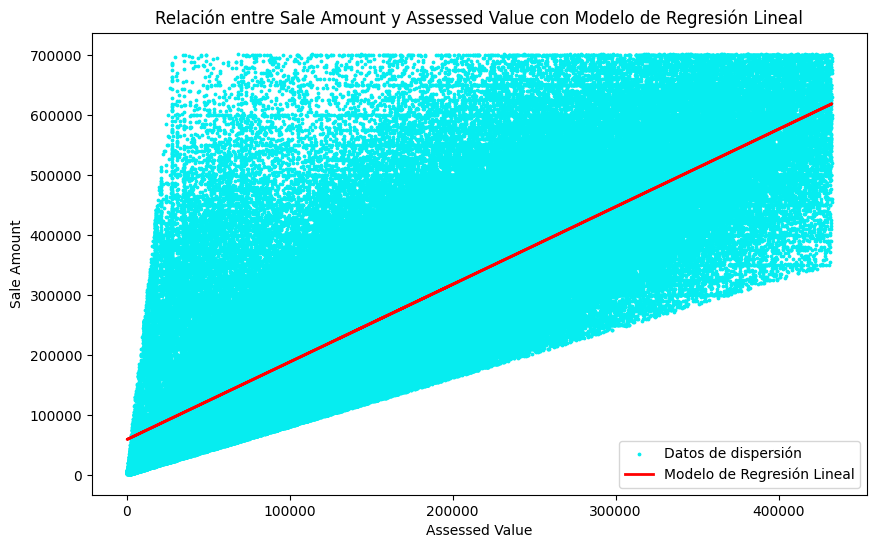

In [77]:
# Visualmente la relacion de mi variable con modelo de regresion lineal
plt.figure(figsize=(10, 6))
plt.scatter(X['Assessed Value'], y, s=3, color='#06EDF0', label='Datos de dispersión')
plt.plot(X['Assessed Value'], modelo_ols.predict(X), color='red', linewidth=2, label='Modelo de Regresión Lineal')
plt.xlabel('Assessed Value')
plt.ylabel('Sale Amount')
plt.title('Relación entre Sale Amount y Assessed Value con Modelo de Regresión Lineal')
plt.legend()
plt.show()

In [78]:
coeficientes = modelo_ols.params
print('Coeficientes:')
print(coeficientes)

Coeficientes:
const            58990.83
Assessed Value       1.29
dtype: float64


In [79]:
intervalo_confianza = modelo_ols.conf_int()
print("Intervalo de confianza de los coeficientes:")
print(intervalo_confianza)

Intervalo de confianza de los coeficientes:
                      0        1
const          58570.57 59411.10
Assessed Value     1.29     1.30


Intervalo de confianza solo tiene valores positivos, esto confirma la pendiente positiva

In [80]:
pvalores = modelo_ols.pvalues
print('P-Valores:')
print(pvalores.round(10))

P-Valores:
const            0.00
Assessed Value   0.00
dtype: float64


El valor p cero (0.000) para "Assessed Value" indica que esta variable es estadísticamente significativa en la predicción del "Sale Amount" en el modelo de regresión lineal.

In [81]:
r_cuadrado = modelo_ols.rsquared
print("Coeficiente de determinación (R-cuadrado):", r_cuadrado.round(3))

Coeficiente de determinación (R-cuadrado): 0.656


---
Continuaremos agregando mas variables a nuestro modelo para verificar si podemos mejorar nuestros resultados.


---

## 2) Variable independiente: "Town_mean"

In [82]:
# Definimos la variable independiente (X) y la variable dependiente (y)
X = df[['Assessed Value', 'Town_mean']]
y = df['Sale Amount']

In [83]:
# Visualizamos X
X.head()

,Assessed Value,Town_mean
1,130400.00,333453.30
2,171360.00,324883.98
3,168900.00,276876.66
5,94920.00,184840.11
7,85680.00,184840.11


In [84]:
# Verificamos presencia de nulos en X
X.isna().sum()

Assessed Value    0
Town_mean         0
dtype: int64

In [85]:
# Agregamos una constante a la variable independiente para incluir el intercepto
X = sm.add_constant(X)

In [86]:
# Ajustamos el modelo de regresión lineal usando OLS
modelo_ols = sm.OLS(y, X).fit()


In [87]:
# Analizamos los resultados del modelo
print(modelo_ols.summary())


                            OLS Regression Results                            
Dep. Variable:            Sale Amount   R-squared:                       0.675
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                 5.561e+05
Date:                Mon, 08 Apr 2024   Prob (F-statistic):               0.00
Time:                        22:34:45   Log-Likelihood:            -6.7916e+06
No. Observations:              535876   AIC:                         1.358e+07
Df Residuals:                  535873   BIC:                         1.358e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           4999.9559    370.963     13.

In [88]:
coeficientes = modelo_ols.params
print('Coeficientes:')
print(coeficientes)

Coeficientes:
const            4999.96
Assessed Value      1.16
Town_mean           0.30
dtype: float64


In [89]:
intervalo_confianza = modelo_ols.conf_int()
print("Intervalo de confianza de los coeficientes:")
print(intervalo_confianza)

Intervalo de confianza de los coeficientes:
                     0       1
const          4272.88 5727.03
Assessed Value    1.16    1.16
Town_mean         0.30    0.30


Intervalo de confianza solo tiene valores positivos, esto confirma la pendiente positiva

In [90]:
pvalores = modelo_ols.pvalues
print('P-Valores:')
print(pvalores.round(10))

P-Valores:
const            0.00
Assessed Value   0.00
Town_mean        0.00
dtype: float64


El valor p cero (0.000) para "Town_mean" indica que esta variable es estadísticamente significativa en la predicción del "Sale Amount" en el modelo de regresión lineal.

In [91]:
r_cuadrado = modelo_ols.rsquared
print("Coeficiente de determinación (R-cuadrado):", r_cuadrado.round(3))

Coeficiente de determinación (R-cuadrado): 0.675


---

El Coeficiente de determinación (R-cuadrado) aumenta unos puntos, por lo que  lo tendremos en cuenta para este modelo.

---


## 3) Variable independiente: "Property_mean"

In [92]:
# Definimos la variable independiente (X) y la variable dependiente (y)
X = df[['Assessed Value', 'Town_mean', 'Property_mean']]
y = df['Sale Amount']

In [93]:
# Visualizamos X
X.head()

,Assessed Value,Town_mean,Property_mean
1,130400.00,333453.30,286765.60
2,171360.00,324883.98,286765.60
3,168900.00,276876.66,286765.60
5,94920.00,184840.11,286765.60
7,85680.00,184840.11,286765.60


In [94]:
# Verificamos presencia de nulos en X
X.isna().sum()

Assessed Value    0
Town_mean         0
Property_mean     0
dtype: int64

In [95]:
# Agregamos una constante a la variable independiente para incluir el intercepto
X = sm.add_constant(X)


In [96]:
# Ajustamos el modelo de regresión lineal usando OLS
modelo_ols = sm.OLS(y, X).fit()


In [97]:
# Analizamos los resultados del modelo
print(modelo_ols.summary())

                            OLS Regression Results                            
Dep. Variable:            Sale Amount   R-squared:                       0.675
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                 3.714e+05
Date:                Mon, 08 Apr 2024   Prob (F-statistic):               0.00
Time:                        22:34:46   Log-Likelihood:            -6.7912e+06
No. Observations:              535876   AIC:                         1.358e+07
Df Residuals:                  535872   BIC:                         1.358e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           3.293e+04   1154.743     28.

In [98]:
r_cuadrado = modelo_ols.rsquared
print("Coeficiente de determinación (R-cuadrado):", r_cuadrado.round(3))

Coeficiente de determinación (R-cuadrado): 0.675


In [99]:
intervalo_confianza = modelo_ols.conf_int()
print("Intervalo de confianza de los coeficientes:")
print(intervalo_confianza)

Intervalo de confianza de los coeficientes:
                      0        1
const          30662.44 35188.96
Assessed Value     1.17     1.18
Town_mean          0.29     0.29
Property_mean     -0.12    -0.10


---
El Coeficiente de determinación (R-cuadrado) no varía.

El intervalo de confianza es negativo y muy bajo.

No tendremos en cuenta Property_mean para este modelo.


---


## 4) Variable independiente: "Residential_mean"

In [100]:
# Definimos la variable independiente (X) y la variable dependiente (y)
X = df[['Assessed Value', 'Town_mean', 'Residential_mean']]
y = df['Sale Amount']

In [101]:
# Visualizamos X
X.head()

,Assessed Value,Town_mean,Residential_mean
1,130400.00,333453.30,203704.24
2,171360.00,324883.98,272105.22
3,168900.00,276876.66,272105.22
5,94920.00,184840.11,272105.22
7,85680.00,184840.11,214684.27


In [102]:
# Verificamos presencia de nulos en X
X.isna().sum()

Assessed Value      0
Town_mean           0
Residential_mean    0
dtype: int64

In [103]:
# Agregamos una constante a la variable independiente para incluir el intercepto
X = sm.add_constant(X)

In [104]:
# Ajustamos el modelo de regresión lineal usando OLS
modelo_ols = sm.OLS(y, X).fit()

In [105]:
# Analizamos los resultados del modelo
print(modelo_ols.summary())

                            OLS Regression Results                            
Dep. Variable:            Sale Amount   R-squared:                       0.677
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                 3.749e+05
Date:                Mon, 08 Apr 2024   Prob (F-statistic):               0.00
Time:                        22:34:46   Log-Likelihood:            -6.7895e+06
No. Observations:              535876   AIC:                         1.358e+07
Df Residuals:                  535872   BIC:                         1.358e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             7.655e+04   1180.805  

In [106]:
r_cuadrado = modelo_ols.rsquared
print("Coeficiente de determinación (R-cuadrado):", r_cuadrado.round(3))

Coeficiente de determinación (R-cuadrado): 0.677


In [107]:
intervalo_confianza = modelo_ols.conf_int()
print("Intervalo de confianza de los coeficientes:")
print(intervalo_confianza)

Intervalo de confianza de los coeficientes:
                        0        1
const            74232.79 78861.47
Assessed Value       1.19     1.20
Town_mean            0.28     0.28
Residential_mean    -0.30    -0.28


---
El Coeficiente de determinación (R-cuadrado) es practicamente igual.

El intervalo de confianza es negativo. Lo cual nos podria causar ambiguedad en nuestro modelo.

No tendremos en cuenta Residential_mean para este modelo.

---


## 5) Variable independiente: "Sales Ratio"

Esta variable no tiene sentido que la incorporemos al modelo de prediccion por que es resultado de la variable que estamos queriendo predecir.

# Conclusiones:

---
* Nos quedaremos con el modelo que tiene las variables independiaentes: 'Assessed Value' y 'Town_mean'. (el número 2).

En este modelo podemos observar:

* Intervalo de confianza solo tiene valores positivos, esto confirma la pendiente positiva.

* Los valor p cero (0.000) para indica que estas variables son estadísticamente significativa en la predicción del "Sale Amount" en el modelo de regresión lineal.

* El Coeficiente de determinación (R-cuadrado) es 0.675, lo que significa que aproximadamente el 67.5% de la variabilidad en "Sale Amount" es explicada por las variables independientes incluidas en tu modelo

---


# Agregamos a nuestro modelo, las variables Dummy y variables nuevas creadas con contenido binario.

In [108]:
# identificaremos las columnas binarias (variables binarias) en este DF las columnas binareas solo tienen valores 0 o 1.
columnas_binarias = [col for col in df.columns if set(df[col]) == {0, 1}]

In [109]:
# Creamos un nuevo objeto Variables_binarias
Variables_binarias = df[columnas_binarias]

In [110]:
Variables_binarias

,Non Use Code_01 - Family,Non Use Code_02 - Love and Affection,Non Use Code_03 - Inter Corporation,Non Use Code_04 - Correcting Deed,Non Use Code_05 - Deed Date,Non Use Code_06 - Portion of Property,Non Use Code_07 - Change in Property,Non Use Code_08 - Part Interest,Non Use Code_09 - Tax,Non Use Code_1,...,Non Use Code_74,Non Use Code_8,Non Use Code_88,Non Use Code_9,Non Use Code_No data,Non Use Code_Single Family,Address_SI_NO,Location_SI_NO,Assessor Remarks_SI_NO,OPM remarks_SI_NO
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,1,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
765739,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
765740,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
765742,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
765747,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


In [111]:
# Definimos la variable independiente (X) y la variable dependiente (y)
# Definimos las características numéricas
caracteristicas_numericas = ['Assessed Value', 'Town_mean'] # Variable que utilizaremos luego del análisis efectuado.

# Creamos un listado que contenga todas las características a incluir en X
columnas_a_incluir = caracteristicas_numericas + columnas_binarias

X = df[columnas_a_incluir]
y = df['Sale Amount']

In [112]:
# Visualizamos X
X.head()

,Assessed Value,Town_mean,Non Use Code_01 - Family,Non Use Code_02 - Love and Affection,Non Use Code_03 - Inter Corporation,Non Use Code_04 - Correcting Deed,Non Use Code_05 - Deed Date,Non Use Code_06 - Portion of Property,Non Use Code_07 - Change in Property,Non Use Code_08 - Part Interest,...,Non Use Code_74,Non Use Code_8,Non Use Code_88,Non Use Code_9,Non Use Code_No data,Non Use Code_Single Family,Address_SI_NO,Location_SI_NO,Assessor Remarks_SI_NO,OPM remarks_SI_NO
1,130400.00,333453.30,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
2,171360.00,324883.98,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
3,168900.00,276876.66,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,1,0,0
5,94920.00,184840.11,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
7,85680.00,184840.11,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0


In [113]:
# Agregamos una constante a la variable independiente para incluir el intercepto
X = sm.add_constant(X)

In [114]:
# Ajustamos el modelo de regresión lineal usando OLS
modelo_ols = sm.OLS(y, X).fit()

In [115]:
# Analizamos los resultados del modelo
print(modelo_ols.summary())

                            OLS Regression Results                            
Dep. Variable:            Sale Amount   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                 2.040e+04
Date:                Mon, 08 Apr 2024   Prob (F-statistic):               0.00
Time:                        22:34:56   Log-Likelihood:            -6.7310e+06
No. Observations:              535876   AIC:                         1.346e+07
Df Residuals:                  535800   BIC:                         1.346e+07
Df Model:                          75                                         
Covariance Type:            nonrobust                                         
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

In [116]:
r_cuadrado = modelo_ols.rsquared
print("Coeficiente de determinación (R-cuadrado):", r_cuadrado.round(3))

Coeficiente de determinación (R-cuadrado): 0.741


Conclusiones
---
Podemos obtener las siguientes observaciones:

* Nuestro R-cuadrado mejoró de 0.675 a 0.741.
* R-squared (R-cuadrado): El valor de R-cuadrado es 0.741, lo que significa que aproximadamente el 74.1% de la variabilidad en "Sale Amount" es explicada por las variables independientes incluidas en el modelo. Esto nos da un indicio de que el modelo de regresión lineal parece tener un buen ajuste.
* Adj. R-squared (R-cuadrado ajustado): Es similar al R-cuadrado, pero ajusta la métrica según el número de variables independientes en el modelo. Un valor alto indica un buen ajuste.
* Es importante prestar atención a los valores p. Los valores p más pequeños indican que las variables son más estadísticamente significativas en la predicción de la variable dependiente. En este modelo algunas variables parecen tener valores p muy altos, lo que sugiere que podrían no ser estadísticamente significativas.



# Analizamos más a detalle los resultados para decidir si es conveniente tomar todas estas variables Dummy incorporadas al modelo.


In [117]:
#Identificamos las columnas con P valores > 0.1
columnas_a_quitar = ['Non Use Code_10','Non Use Code_15','Non Use Code_16','Non Use Code_17','Non Use Code_18','Non Use Code_17 - Two Towns',
                     'Non Use Code_19','Non Use Code_2','Non Use Code_20 - Cemetery','Non Use Code_21','Non Use Code_29 - No Consideration','Non Use Code_26',
                     'Non Use Code_30','Non Use Code_32','Non Use Code_37','Non Use Code_38','Non Use Code_4','Non Use Code_5','Non Use Code_6',
                     'Non Use Code_55','Non Use Code_73','Non Use Code_88','Non Use Code_Single Family','Address_SI_NO']
columnas_a_quitar

['Non Use Code_10',
 'Non Use Code_15',
 'Non Use Code_16',
 'Non Use Code_17',
 'Non Use Code_18',
 'Non Use Code_17 - Two Towns',
 'Non Use Code_19',
 'Non Use Code_2',
 'Non Use Code_20 - Cemetery',
 'Non Use Code_21',
 'Non Use Code_29 - No Consideration',
 'Non Use Code_26',
 'Non Use Code_30',
 'Non Use Code_32',
 'Non Use Code_37',
 'Non Use Code_38',
 'Non Use Code_4',
 'Non Use Code_5',
 'Non Use Code_6',
 'Non Use Code_55',
 'Non Use Code_73',
 'Non Use Code_88',
 'Non Use Code_Single Family',
 'Address_SI_NO']

In [118]:
# Quitaremos las columnas binarias cuyo P valor es mayor a 0.1 y volveremos a calcular nuestro R 2

# Convertiremos las listas a conjuntos y aplicar la diferencia
columnas_binarias_filtrado = list(set(columnas_binarias) - set(columnas_a_quitar))

# Mostramos resultado
columnas_binarias_filtrado

['Non Use Code_27 - CRUMBLING FOUNDATION ASSESSMENT REDUCTION',
 'Non Use Code_11 - Court Order',
 'Non Use Code_18 - In Lieu Of Foreclosure',
 'Non Use Code_01 - Family',
 'Non Use Code_08 - Part Interest',
 'Non Use Code_14',
 'Non Use Code_12',
 'Non Use Code_02 - Love and Affection',
 'Non Use Code_22 - Money and Personal Property',
 'Location_SI_NO',
 'Non Use Code_29',
 'Non Use Code_16 - Charitable Group',
 'Non Use Code_28 - Use Assessment',
 'Non Use Code_3',
 'Non Use Code_15 - Government Agency',
 'Non Use Code_No data',
 'Non Use Code_21 - Personal Property Exchange',
 'Non Use Code_22',
 'Non Use Code_74',
 'Non Use Code_28',
 'Assessor Remarks_SI_NO',
 'Non Use Code_8',
 'OPM remarks_SI_NO',
 'Non Use Code_23',
 'Non Use Code_07 - Change in Property',
 'Non Use Code_24 - Plottage',
 'Non Use Code_10 - A Will',
 'Non Use Code_23 - Zoning',
 'Non Use Code_25 - Other',
 'Non Use Code_9',
 'Non Use Code_24',
 'Non Use Code_13',
 'Non Use Code_06 - Portion of Property',
 'Non 

In [119]:
# Definimos la variable independiente (X) y la variable dependiente (y)
# Definimos las características numéricas
caracteristicas_numericas = ['Assessed Value', 'Town_mean'] # Variable que utilizaremos luego del análisis efectuado.

# Creamos un listado que contenga todas las características a incluir en X
columnas_a_incluir = caracteristicas_numericas + columnas_binarias_filtrado
X = df[columnas_a_incluir]
y = df['Sale Amount']

In [120]:
# Visualizamos X
X.head()

,Assessed Value,Town_mean,Non Use Code_27 - CRUMBLING FOUNDATION ASSESSMENT REDUCTION,Non Use Code_11 - Court Order,Non Use Code_18 - In Lieu Of Foreclosure,Non Use Code_01 - Family,Non Use Code_08 - Part Interest,Non Use Code_14,Non Use Code_12,Non Use Code_02 - Love and Affection,...,Non Use Code_03 - Inter Corporation,Non Use Code_25,Non Use Code_05 - Deed Date,Non Use Code_27,Non Use Code_30 - Auction,Non Use Code_1,Non Use Code_09 - Tax,Non Use Code_26 - Rehabilitation Deferred,Non Use Code_04 - Correcting Deed,Non Use Code_12 - Non Buildable Lot
1,130400.00,333453.30,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,171360.00,324883.98,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,168900.00,276876.66,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,94920.00,184840.11,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,85680.00,184840.11,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [121]:
# Agregamos una constante a la variable independiente para incluir el intercepto
X = sm.add_constant(X)

In [122]:
# Ajustamos el modelo de regresión lineal usando OLS
modelo_ols = sm.OLS(y, X).fit()

In [123]:
# Analizamos los resultados del modelo
print(modelo_ols.summary())

                            OLS Regression Results                            
Dep. Variable:            Sale Amount   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                 2.941e+04
Date:                Mon, 08 Apr 2024   Prob (F-statistic):               0.00
Time:                        22:35:00   Log-Likelihood:            -6.7310e+06
No. Observations:              535876   AIC:                         1.346e+07
Df Residuals:                  535823   BIC:                         1.346e+07
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

In [124]:
r_cuadrado = modelo_ols.rsquared
print("Coeficiente de determinación (R-cuadrado):", r_cuadrado.round(3))

Coeficiente de determinación (R-cuadrado): 0.741


---

Al quitar las variables con P valores > 0.05 podemos observar que el R-cuadrado continua siendo de 0.741.
Es por esto que utilizaremos este modelo, con P valores < 0.05 que fue el umbral definido para el análisis.

---

# Buscamos posible problema de Varianza
Un posible problema en la varianza del modelo significa que las métricas de validación en distintas submuestras es muy diferente, por lo que podríamos tener problemas de **Generalización**.

In [125]:
# Generamos el DF que utilizaremos para la validación.
df_cross = df.select_dtypes(include=[np.number])
df_cross

,Serial Number,List Year,Assessed Value,Sale Amount,Sales Ratio,Sale Amount Log,Town_mean,Property_mean,Residential_mean,Non Use Code_01 - Family,...,Non Use Code_8,Non Use Code_88,Non Use Code_9,Non Use Code_No data,Non Use Code_Single Family,Address_SI_NO,Location_SI_NO,Assessor Remarks_SI_NO,OPM remarks_SI_NO,TRAIN
1,200212,2020,130400.00,179900.00,0.72,12.10,333453.30,286765.60,203704.24,0,...,0,0,0,1,0,1,0,0,0,1
2,20139,2020,171360.00,335000.00,0.51,12.72,324883.98,286765.60,272105.22,0,...,0,0,0,1,0,1,0,0,0,1
3,200086,2020,168900.00,352000.00,0.48,12.77,276876.66,286765.60,272105.22,0,...,0,0,0,1,0,1,1,0,0,1
5,200032,2020,94920.00,155000.00,0.61,11.95,184840.11,286765.60,272105.22,0,...,0,0,0,1,0,1,0,0,0,1
7,200527,2020,85680.00,183000.00,0.47,12.12,184840.11,286765.60,214684.27,0,...,0,0,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
765739,190365,2019,315420.00,380000.00,0.83,12.85,291752.20,267934.88,272105.22,0,...,0,0,0,1,0,1,0,0,0,1
765740,190159,2019,128700.00,175000.00,0.74,12.07,239985.19,202147.57,203704.24,0,...,0,0,0,1,0,1,0,0,0,1
765742,191401,2019,81070.00,142000.00,0.57,11.86,135692.38,267934.88,272105.22,0,...,0,0,0,1,0,1,0,0,0,1
765747,190284,2019,68280.00,76000.00,0.90,11.24,135692.38,267934.88,272105.22,0,...,0,0,0,0,0,1,0,1,0,1


In [126]:
# Quitamos columnas que no tenemos que tener en cuenta ya que tienen correlacion directa con Sale Amount
df_cross = df_cross.drop(['Sales Ratio','Sale Amount Log','List Year'], axis=1)
df_cross

,Serial Number,Assessed Value,Sale Amount,Town_mean,Property_mean,Residential_mean,Non Use Code_01 - Family,Non Use Code_02 - Love and Affection,Non Use Code_03 - Inter Corporation,Non Use Code_04 - Correcting Deed,...,Non Use Code_8,Non Use Code_88,Non Use Code_9,Non Use Code_No data,Non Use Code_Single Family,Address_SI_NO,Location_SI_NO,Assessor Remarks_SI_NO,OPM remarks_SI_NO,TRAIN
1,200212,130400.00,179900.00,333453.30,286765.60,203704.24,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
2,20139,171360.00,335000.00,324883.98,286765.60,272105.22,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
3,200086,168900.00,352000.00,276876.66,286765.60,272105.22,0,0,0,0,...,0,0,0,1,0,1,1,0,0,1
5,200032,94920.00,155000.00,184840.11,286765.60,272105.22,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
7,200527,85680.00,183000.00,184840.11,286765.60,214684.27,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
765739,190365,315420.00,380000.00,291752.20,267934.88,272105.22,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
765740,190159,128700.00,175000.00,239985.19,202147.57,203704.24,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
765742,191401,81070.00,142000.00,135692.38,267934.88,272105.22,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
765747,190284,68280.00,76000.00,135692.38,267934.88,272105.22,0,0,0,0,...,0,0,0,0,0,1,0,1,0,1


In [127]:
# Definimos el tamaño de la muestra que deseas utilizar
# Establecemos la semilla aleatoria para reproducibilidad
np.random.seed(22)

# Tomar el 10% de tu DataFrame original de manera aleatoria
muestra_df_cross = df_cross.sample(frac=0.1)

In [128]:
# Obtengo data en values
X = muestra_df_cross.drop(columns = 'Sale Amount').values
y = muestra_df_cross['Sale Amount'].values

# Librerias
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

# Crear el modelo
model_22 = RandomForestRegressor(random_state = 22,
                              n_estimators = 20,
                              max_depth = 100,
                              max_features = 50,
                              min_samples_leaf = 1)

k_elegido = 22

scores22 = cross_val_score(model_22, X, y, cv=k_elegido, scoring='r2')

scores_df22 = pd.DataFrame({'K_orden': range(1,k_elegido+1),
                          'Scores' : scores22})

scores_df22

,K_orden,Scores
0,1,0.83
1,2,0.80
2,3,0.84
3,4,0.83
4,5,0.83
5,6,0.81
6,7,0.83
7,8,0.84
8,9,0.82
9,10,0.84


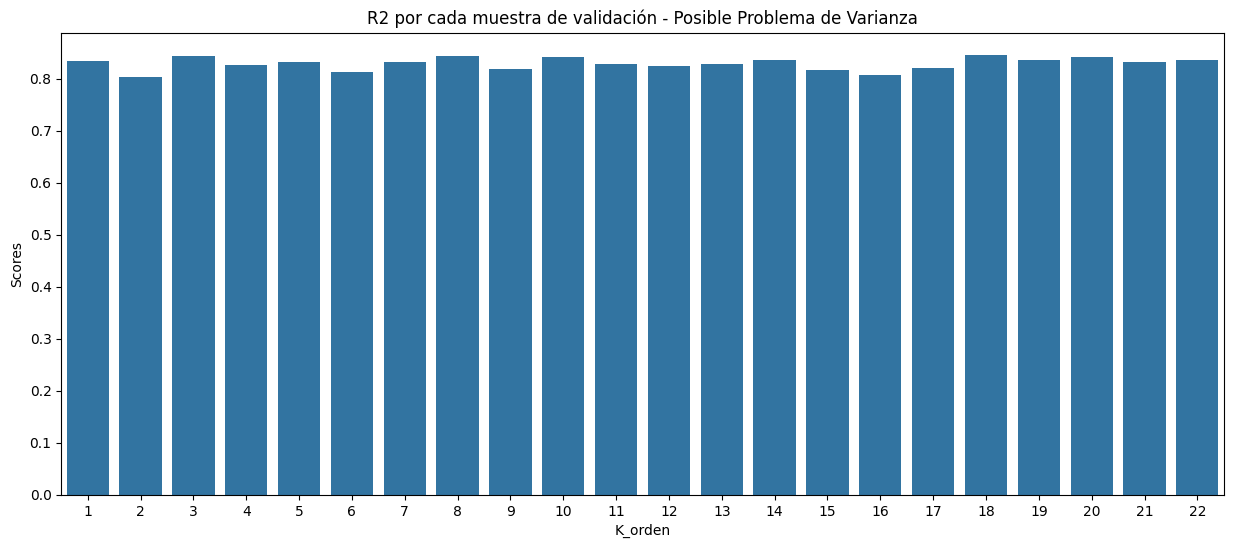

In [129]:
# Visualmente
plt.figure(figsize=(15, 6))
sns.barplot(data = scores_df22,
              x = 'K_orden',
              y = 'Scores')
plt.title('R2 por cada muestra de validación - Posible Problema de Varianza')
plt.show()

In [130]:
# Metricas
media_1 = scores_df22['Scores'].mean()
desvio_1 = scores_df22['Scores'].std()

print('R2 Promedio: ', round(media_1,4))
print('R2 Desvio: ', round(desvio_1,4))
print('R2 CV: ', round(desvio_1 / media_1,4))

R2 Promedio:  0.8291
R2 Desvio:  0.0119
R2 CV:  0.0143


---
Con esta configuración no se detecta problema de Varianza.

Se realizaron multiples pruebas con diferentes muestras, todas nos dieron resultados practicamente iguales. Por esto es que optamos por dejar la muestra del 10 % de los datos.

---


# Buscamos posible problema de sesgo
Un posible problema en el sesgo del modelo significa que el modelo no es lo suficientemente complejo como para capturar las verdaderas relaciones, así que estoy ante un caso de **Underfitting**.

In [131]:
# Obtengo data en values
X = muestra_df_cross.drop(columns = 'Sale Amount').values
y = muestra_df_cross['Sale Amount'].values

# Librerias
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

# Crear el modelo
model_23 = RandomForestRegressor(random_state = 22,
                              n_estimators = 200,
                              max_depth = 2,
                              max_features = 20,
                              min_samples_leaf = 50)

k_elegido = 4

scores23 = cross_val_score(model_23, X, y, cv=k_elegido, scoring='r2')

scores_df23 = pd.DataFrame({'K_orden': range(1,k_elegido+1),
                          'Scores' : scores23})

scores_df23

,K_orden,Scores
0,1,0.41
1,2,0.43
2,3,0.44
3,4,0.43


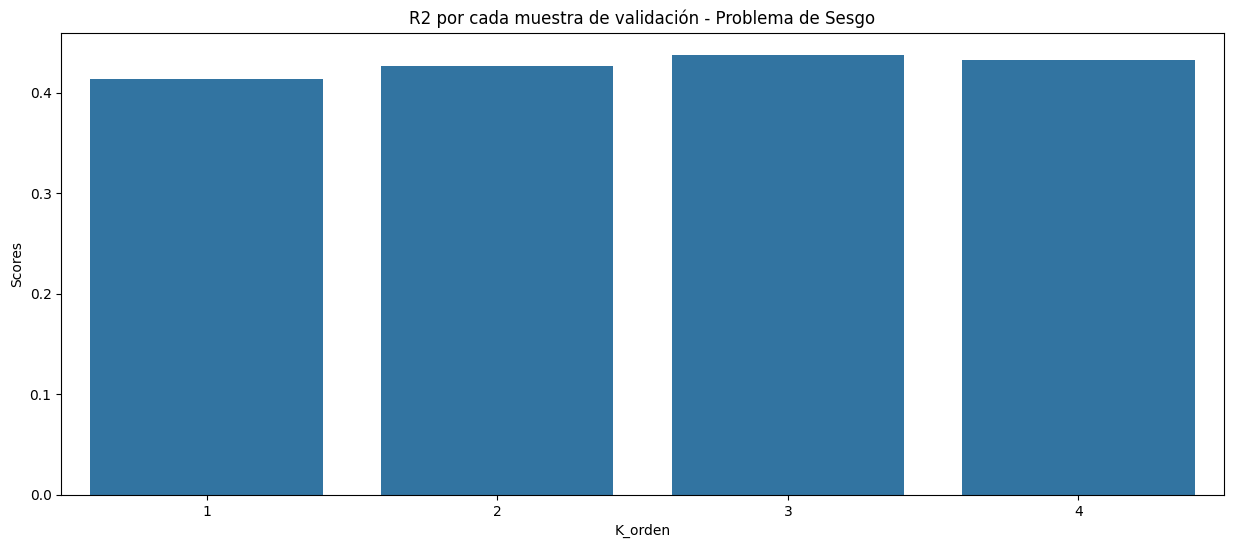

In [132]:
# Visualmente
plt.figure(figsize=(15, 6))
sns.barplot(data = scores_df23,
              x = 'K_orden',
              y = 'Scores')
plt.title('R2 por cada muestra de validación - Problema de Sesgo')
plt.show()

In [133]:
# Metricas
media_1 = scores_df23['Scores'].mean()
desvio_1 = scores_df23['Scores'].std()

print('R2 Promedio: ', round(media_1,4))
print('R2 Desvio: ', round(desvio_1,4))
print('R2 CV: ', round(desvio_1 / media_1,4))

R2 Promedio:  0.4277
R2 Desvio:  0.0105
R2 CV:  0.0245


---
Analizando los resultados podemos observar que todas las metricas empeoraron notoriamente.

---


# Modelo de testeo y resultados

In [134]:
DF_TEST.info

<bound method DataFrame.info of         Serial Number  List Year Date Recorded           Town  \
0               20002       2020    2020-10-02        Ashford   
4              201295       2020    2021-09-09        Bristol   
6              200354       2020    2020-12-29        Bristol   
8              201212       2020    2021-08-23        Bristol   
10             200117       2020    2021-04-12         Canton   
...               ...        ...           ...            ...   
765743         190302       2019    2019-11-29      Waterbury   
765744         190161       2019    2020-03-02      Newington   
765745          19921       2019    2019-11-18     West Haven   
765746         190272       2019    2020-06-24     New London   
765748         190129       2019    2020-04-27  Windsor Locks   

                Address  Assessed Value  Sale Amount  Sales Ratio  \
0       390 TURNPIKE RD       253000.00    430000.00         0.59   
4           609 CAMP ST       144340.00    249900.00         0.58   
6        391 TIFFANY LA       173740.00    299000.00         0.58   
8       8 JENNINGS TERR        88060.00     91000.00         0.97   
10      52 COUNTRY LANE       160850.00    280000.00         0.57   
...                 ...             ...          ...          ...   
765743   122 WOLCOTT ST        77870.00    112000.00         0.70   
765744  22 ROCKLEDGE DR       306000.00    456000.00         0.67   
765745     75 CLOVER ST       125230.00    246000.00         0.51   
765746      4 BISHOP CT        60410.00     53100.00         1.14   
765748   19 HATHAWAY ST       121450.00    210000.00         0.58   

        Property Type Residential Type  ... Non Use Code_8 Non Use Code_88  \
0         Residential    Single Family  ...              0               0   
4         Residential    Single Family  ...              0               0   
6         Residential    Single Family  ...              0               0   
8         Residential    Single Family  ...              0               0   
10        Residential    Single Family  ...              0               0   
...               ...              ...  ...            ...             ...   
765743   Three Family     Three Family  ...              0               0   
765744  Single Family    Single Family  ...              0               0   
765745  Single Family    Single Family  ...              0               0   
765746  Single Family    Single Family  ...              0               0   
765748  Single Family    Single Family  ...              0               0   

       Non Use Code_9  Non Use Code_No data  Non Use Code_Single Family  \
0                   0                     1                           0   
4                   0                     1                           0   
6                   0                     1                           0   
8                   0                     0                           0   
10                  0                     1                           0   
...               ...                   ...                         ...   
765743              0                     1                           0   
765744              0                     1                           0   
765745              0                     1                           0   
765746              0                     0                           0   
765748              0                     1                           0   

        Address_SI_NO  Location_SI_NO  Assessor Remarks_SI_NO  \
0                   1               0                       0   
4                   1               0                       0   
6                   1               0                       0   
8                   1               0                       1   
10                  1               0                       0   
...               ...             ...                     ...   
765743              1               0                       0   


## Analizamos nuestro modelo de regresión lineal en DF_TEST incorporando todas las variables nuevas.

In [135]:
# identificaremos las columnas binarias (variables binarias) en este DF_TEST las columnas binareas solo tienen valores 0 o 1.
columnas_binarias_TEST = [col for col in DF_TEST.columns if set(DF_TEST[col]) == {0, 1}]

In [136]:
# Creamos un nuevo objeto Variables_binarias_TEST
Variables_binarias_TEST = DF_TEST[columnas_binarias_TEST]

In [137]:
Variables_binarias_TEST

,Non Use Code_01 - Family,Non Use Code_02 - Love and Affection,Non Use Code_03 - Inter Corporation,Non Use Code_04 - Correcting Deed,Non Use Code_05 - Deed Date,Non Use Code_06 - Portion of Property,Non Use Code_07 - Change in Property,Non Use Code_08 - Part Interest,Non Use Code_09 - Tax,Non Use Code_1,...,Non Use Code_7,Non Use Code_73,Non Use Code_8,Non Use Code_9,Non Use Code_No data,Non Use Code_Single Family,Address_SI_NO,Location_SI_NO,Assessor Remarks_SI_NO,OPM remarks_SI_NO
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
765743,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
765744,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
765745,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,1,0,0
765746,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [138]:
#Identificamos las columnas con P valores > 0.1
columnas_a_quita_TEST = ['Non Use Code_10','Non Use Code_15','Non Use Code_16','Non Use Code_17','Non Use Code_18','Non Use Code_17 - Two Towns',
                     'Non Use Code_19','Non Use Code_2','Non Use Code_20 - Cemetery','Non Use Code_21','Non Use Code_29 - No Consideration','Non Use Code_26',
                     'Non Use Code_30','Non Use Code_32','Non Use Code_37','Non Use Code_38','Non Use Code_4','Non Use Code_5','Non Use Code_6',
                     'Non Use Code_55','Non Use Code_73','Non Use Code_88','Non Use Code_Single Family','Address_SI_NO']
columnas_a_quita_TEST

['Non Use Code_10',
 'Non Use Code_15',
 'Non Use Code_16',
 'Non Use Code_17',
 'Non Use Code_18',
 'Non Use Code_17 - Two Towns',
 'Non Use Code_19',
 'Non Use Code_2',
 'Non Use Code_20 - Cemetery',
 'Non Use Code_21',
 'Non Use Code_29 - No Consideration',
 'Non Use Code_26',
 'Non Use Code_30',
 'Non Use Code_32',
 'Non Use Code_37',
 'Non Use Code_38',
 'Non Use Code_4',
 'Non Use Code_5',
 'Non Use Code_6',
 'Non Use Code_55',
 'Non Use Code_73',
 'Non Use Code_88',
 'Non Use Code_Single Family',
 'Address_SI_NO']

In [139]:
# Quitaremos las columnas binarias cuyo P valor es mayor a 0.1 y volveremos a calcular nuestro R 2

# Convertiremos las listas a conjuntos y aplicar la diferencia
columnas_binarias_filtrado_TEST = list(set(columnas_binarias) - set(columnas_a_quita_TEST))

# Mostramos resultado
columnas_binarias_filtrado_TEST

['Non Use Code_27 - CRUMBLING FOUNDATION ASSESSMENT REDUCTION',
 'Non Use Code_11 - Court Order',
 'Non Use Code_18 - In Lieu Of Foreclosure',
 'Non Use Code_01 - Family',
 'Non Use Code_08 - Part Interest',
 'Non Use Code_14',
 'Non Use Code_12',
 'Non Use Code_02 - Love and Affection',
 'Non Use Code_22 - Money and Personal Property',
 'Location_SI_NO',
 'Non Use Code_29',
 'Non Use Code_16 - Charitable Group',
 'Non Use Code_28 - Use Assessment',
 'Non Use Code_3',
 'Non Use Code_15 - Government Agency',
 'Non Use Code_No data',
 'Non Use Code_21 - Personal Property Exchange',
 'Non Use Code_22',
 'Non Use Code_74',
 'Non Use Code_28',
 'Assessor Remarks_SI_NO',
 'Non Use Code_8',
 'OPM remarks_SI_NO',
 'Non Use Code_23',
 'Non Use Code_07 - Change in Property',
 'Non Use Code_24 - Plottage',
 'Non Use Code_10 - A Will',
 'Non Use Code_23 - Zoning',
 'Non Use Code_25 - Other',
 'Non Use Code_9',
 'Non Use Code_24',
 'Non Use Code_13',
 'Non Use Code_06 - Portion of Property',
 'Non 

In [140]:
# Definimos la variable independiente (X) y la variable dependiente (y)
# Definimos las características numéricas
caracteristicas_numericas_TEST = ['Assessed Value', 'Town_mean']

# Creamos un listado que contenga todas las características a incluir en X
columnas_a_incluir_TEST = caracteristicas_numericas_TEST + columnas_binarias_filtrado_TEST

X = DF_TEST[columnas_a_incluir_TEST]
y = DF_TEST['Sale Amount']

In [141]:
# Visualizamos X
X.head()

,Assessed Value,Town_mean,Non Use Code_27 - CRUMBLING FOUNDATION ASSESSMENT REDUCTION,Non Use Code_11 - Court Order,Non Use Code_18 - In Lieu Of Foreclosure,Non Use Code_01 - Family,Non Use Code_08 - Part Interest,Non Use Code_14,Non Use Code_12,Non Use Code_02 - Love and Affection,...,Non Use Code_03 - Inter Corporation,Non Use Code_25,Non Use Code_05 - Deed Date,Non Use Code_27,Non Use Code_30 - Auction,Non Use Code_1,Non Use Code_09 - Tax,Non Use Code_26 - Rehabilitation Deferred,Non Use Code_04 - Correcting Deed,Non Use Code_12 - Non Buildable Lot
0,253000.00,183312.62,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,144340.00,184840.11,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,173740.00,184840.11,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,88060.00,184840.11,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,160850.00,279399.86,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [142]:
# Agregamos una constante a la variable independiente para incluir el intercepto
X = sm.add_constant(X)

In [143]:
# Ajustamos el modelo de regresión lineal usando OLS
modelo_ols = sm.OLS(y, X).fit()

In [144]:
# Analizamos los resultados del modelo
print(modelo_ols.summary())

                            OLS Regression Results                            
Dep. Variable:            Sale Amount   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                 1.302e+04
Date:                Mon, 08 Apr 2024   Prob (F-statistic):               0.00
Time:                        22:36:36   Log-Likelihood:            -2.8872e+06
No. Observations:              229874   AIC:                         5.774e+06
Df Residuals:                  229823   BIC:                         5.775e+06
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

In [145]:
r_cuadrado = modelo_ols.rsquared
print("Coeficiente de determinación (R-cuadrado):", r_cuadrado.round(3))

Coeficiente de determinación (R-cuadrado): 0.739




# Conclusiones DF_TEST
---
Al contar con resultados muy similares tanto en DF_TRAIN como en DF_TEST podríamos decir que no estamos en presencia de sobreajuste o subajuste

---

# Optimización de Modelos de Machine Learning

In [146]:
#importamos librerias necesarias.

from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [147]:
# Definimos el tamaño de la muestra que deseas utilizar
# Establecemos la semilla aleatoria para reproducibilidad
np.random.seed(22)

# Tomar el 1 % de tu DataFrame original de manera aleatoria
muestra_train = df.sample(frac=0.01)

In [148]:
# creamos X_train, y_train, X_test e y_test
X_train = muestra_train[columnas_a_incluir]
y_train = muestra_train['Sale Amount']

# Y lo mismo para el conjunto de prueba
X_test = DF_TEST[columnas_a_incluir_TEST]
y_test = DF_TEST['Sale Amount']

In [149]:
# Definir el modelo de regresión lineal
modelo_hiperparametro = LinearRegression()

In [150]:
# Definir el pipeline con transformaciones polinomiales y el modelo de regresión lineal
pipeline = Pipeline([
    ('polinomio', PolynomialFeatures()),  # Transformaciones polinomiales
    ('regresion', modelo_hiperparametro)  # Modelo de regresión lineal
])

In [151]:
# Definir los parámetros para el grado del polinomio
parametros = {
    'polinomio__degree': [1, 2, 3]  # Grados del polinomio a probar
}

In [152]:
# Configurar la búsqueda de hiperparámetros con validación cruzada
grid_search = GridSearchCV(pipeline, parametros, cv=5, scoring='neg_mean_squared_error')

In [153]:
# Ajustar el modelo
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('polinomio', PolynomialFeatures()),
                                       ('regresion', LinearRegression())]),
             param_grid={'polinomio__degree': [1, 2, 3]},
             scoring='neg_mean_squared_error')

In [154]:
# Ver los mejores parámetros y el mejor score
print("Mejores parámetros:", grid_search.best_params_)
print("Mejor score (MSE):", -grid_search.best_score_)

Mejores parámetros: {'polinomio__degree': 1}
Mejor score (MSE): 5169868699.2113695


In [155]:
# Acceder al objeto PolynomialFeatures desde el pipeline
polynomial_features = pipeline.steps[0][1]  # Utiliza el índice del paso en el pipeline

# Obtener el grado del polinomio
grado_pol = polynomial_features.degree
print("El modelo OLS está utilizando un polinomio de grado:", grado_pol)

El modelo OLS está utilizando un polinomio de grado: 2


In [156]:
from sklearn.metrics import r2_score

# Modificar el grado del polinomio en el pipeline y veremos resultados
# Entrenar el modelo con tus datos de entrenamiento
pipeline.fit(X_train, y_train)

# Calcular las predicciones del modelo con los datos de prueba
y_pred = pipeline.predict(X_test)
# Calcular R^2 con los nuevos resultados
r2 = r2_score(y_test, y_pred)
print("Coeficiente de determinación (R^2) con polinomio de grado 1:", r2)

Coeficiente de determinación (R^2) con polinomio de grado 1: 0.7056764717873178


In [157]:
# Evaluar el modelo en el conjunto de prueba
y_pred = grid_search.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred)
print(f"MSE en el conjunto de prueba: {mse_test}")

MSE en el conjunto de prueba: 4793235737.679998


---

Conclusión:

Llevamos a cabo un análisis de hiperparámetros en nuestro modelo de regresión, el cual arrojó los siguientes resultados:

Mejores parámetros encontrados: {'polinomio__degree': 1}
Mejor score obtenido (MSE): 5169868699.211086
Originalmente, estábamos utilizando un polinomio de grado 2 en nuestro modelo de regresión lineal. Al reemplazar este polinomio de grado 2 por uno de grado 1, observamos que el coeficiente de determinación (R²) es inferior al obtenido con el modelo original.

Dado este resultado, hemos decidido continuar utilizando el modelo de regresión lineal original, con el polinomio de grado 2.

---